In [93]:
# --- Make local package importable (robust for notebooks in subfolders) ---
import sys
from pathlib import Path

def add_src_to_path(pkg="quantlib", levels_up=3):
    here = Path.cwd().resolve()
    candidates = [here / "src"]
    # also check parents: ../src, ../../src, ...
    for i in range(1, levels_up+1):
        candidates.append(here.parents[i-1] / "src")
    for p in candidates:
        if (p / pkg / "__init__.py").exists():
            sys.path.insert(0, str(p))
            print(f"[OK] Added to sys.path: {p}")
            return p
    raise FileNotFoundError("Could not find src/quantlib/__init__.py relative to this notebook.")

add_src_to_path()


[OK] Added to sys.path: C:\Users\quantbase\Desktop\quant\src


WindowsPath('C:/Users/quantbase/Desktop/quant/src')

In [138]:
Quant Library Roadmap
├─ 0. Ingestion & Preparation
│  ├─ Data Loading            – Read OHLCV data from CSVs or Jugaad API  [pandas]
│  ├─ Schema Normalization    – Standardize columns (date, open, high, low, close, volume) [pandas]
│  └─ Calendar Alignment      – Align symbols on common trading days (inner join) [pandas]
│
├─ 1. Returns Engine
│  ├─ Compute Returns         – Daily simple and log returns per asset [pandas, numpy]
│  └─ Rolling Windows         – Rolling returns for 1W, 1M, 1Q, 1Y (5/21/63/252 days) [pandas]
│
├─ 2. Statistical Measures
│  ├─ Rolling Stats           – Rolling mean, stdev, and z‑scores for each window [pandas]
│  └─ Portfolio Aggregation   – Compute weighted portfolio returns and volatility [pandas, numpy]
│
├─ 3. Correlation & Beta
│  ├─ Pairwise Correlation    – Full‑sample & rolling correlation matrices [pandas]
│  └─ Beta Calculation        – β(stock←index) and reverse β via cov/var [pandas, numpy]
│
├─ 4. PDFs & Distributions
│  ├─ Empirical PDFs          – Histograms & KDEs of realised returns [scipy.stats, matplotlib]
│  └─ Parametric Fits         – Fit Normal and Student‑t distributions [scipy.stats]
│
├─ 5. Realised Volatility & EWMA
│  └─ EWMA Calculation        – Exponentially weighted vol (λ=0.94/0.97) and annualisation [pandas]
│
├─ 6. Future Returns Distribution
│  └─ EWMA Variance Forecasts – Use final EWMA variance to simulate future returns (Normal or t) [numpy, scipy.stats]
│
└─ 7. Portfolio Risk Analysis
   ├─ Portfolio Statistics    – Compute μ, σ, and annualised vol for any weight vector [numpy, pandas]
   └─ VaR & ES                – Calculate historical VaR/ES and parametric VaR/ES [numpy]

SyntaxError: invalid syntax (2347789264.py, line 1)

In [1]:
# --- 1) LOAD & TIDY ----------------------------------------------------------
import pandas as pd
import numpy as np

# Pick one blue-chip CSV (edit this path)
CSV_PATH = r"C:\Users\quantbase\Desktop\NSE Stocks Data\data\equities\HDFCBANK.csv"


# Minimal column standardization for Jugaad-style bhavcopies
RENAME = {
    "DATE":"date", "OPEN":"open", "HIGH":"high", "LOW":"low", "CLOSE":"close",
    "VOLUME":"volume", "SYMBOL":"symbol", "SERIES":"series"
}

def load_one_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = df.rename(columns=RENAME)
    # Keep the essentials; silently ignore missing optional columns
    keep = [c for c in ["date","symbol","series","open","high","low","close","volume"] if c in df.columns]
    df = df[keep].copy()

    # Parse date, sort, drop duplicate dates (keep first), set index
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.dropna(subset=["date"]).sort_values("date")
    df = df[~df["date"].duplicated(keep="first")]
    df = df.set_index("date")
    df.index = pd.to_datetime(df.index).normalize()  # ensure pure dates

    # Ensure numeric close; remove non-positive as NaN (safety)
    if "close" in df.columns:
        df["close"] = pd.to_numeric(df["close"], errors="coerce")
        df.loc[df["close"] <= 0, "close"] = np.nan

    return df

px = load_one_csv(CSV_PATH)
px.head()


,symbol,series,open,high,low,close,volume
date,,,,,,,
2022-03-30,HDFCBANK,EQ,1472.0,1482.75,1454.05,1476.95,10054871
2022-03-31,HDFCBANK,EQ,1471.0,1484.70,1465.90,1470.35,7147857
2022-04-01,HDFCBANK,EQ,1476.4,1510.00,1470.30,1506.00,7284278
2022-04-04,HDFCBANK,EQ,1580.0,1722.10,1562.55,1656.80,48725485
2022-04-05,HDFCBANK,EQ,1666.7,1666.70,1602.00,1608.25,15461291


In [2]:
# --- 2) HYGIENE SUMMARY ------------------------------------------------------
def summarize_prices(df: pd.DataFrame, name: str = "DF") -> None:
    nrows, ncols = df.shape
    idx = df.index
    print(f"[{name}] shape: {nrows} rows × {ncols} cols")
    if len(idx) > 0:
        print(f"[{name}] date range: {idx.min().date()} → {idx.max().date()}  (days: {len(idx)})")
    # Key checks
    print(f"[{name}] NaNs in close:", df["close"].isna().sum() if "close" in df else "n/a")
    print(f"[{name}] unique dates:", idx.nunique(), "| duplicate dates present:", (idx.nunique() != len(idx)))
    try:
        print(f"[{name}] inferred freq:", pd.infer_freq(idx))
    except Exception:
        print(f"[{name}] inferred freq: None")

summarize_prices(px, "px")


[px] shape: 856 rows × 7 cols
[px] date range: 2022-03-30 → 2025-09-09  (days: 856)
[px] NaNs in close: 0
[px] unique dates: 856 | duplicate dates present: False
[px] inferred freq: None


In [3]:
# --- 3) ALIGN TO CALENDAR (NaN for pre-IPO & non-trading) --------------------
def align_price_to_calendar(df: pd.DataFrame,
                            calendar: pd.DatetimeIndex,
                            col: str = "close") -> pd.Series:
    """
    Reindex 'col' to 'calendar' with NO filling.
    - Pre-IPO (before first valid) stays NaN.
    - Non-trading days stay NaN.
    """
    s = df[col].copy()
    s = s.reindex(calendar)                # align to calendar
    first_valid = s.first_valid_index()
    if first_valid is not None:
        # Guard (usually already NaN pre-IPO, but enforce explicitly)
        s.loc[s.index < first_valid] = np.nan
    return s

# Example calendar (business days over this stock's span).
# Later: replace with your anchor calendar (from blue-chips).
calendar = pd.date_range(px.index.min(), px.index.max(), freq="B")

px_aligned = align_price_to_calendar(px, calendar, col="close")

print("Aligned series:")
print("  length:", len(px_aligned))
print("  first valid:", px_aligned.first_valid_index().date() if px_aligned.first_valid_index() else None)
print("  NaNs total:", int(px_aligned.isna().sum()))
px_aligned.head(10)


Aligned series:
  length: 900
  first valid: 2022-03-30
  NaNs total: 49


2022-03-30    1476.95
2022-03-31    1470.35
2022-04-01    1506.00
2022-04-04    1656.80
2022-04-05    1608.25
2022-04-06    1550.85
2022-04-07    1516.75
2022-04-08    1514.65
2022-04-11    1496.15
2022-04-12    1493.50
Freq: B, Name: close, dtype: float64

In [4]:
from pathlib import Path
import pandas as pd
import numpy as np


In [5]:
# Minimal rename map
RENAME = {"DATE":"date", "CLOSE":"close", "SYMBOL":"symbol", "SERIES":"series"}
SERIES_FILTER = {"EQ"}  # keep cash equities if SERIES exists

def load_close_series(csv_path: str) -> pd.Series:
    """
    Load one CSV → return a Close-price Series named with its SYMBOL.
    Index = date (normalized), values = close (float), pre-cleaned of non-positive.
    """
    # Read available columns only
    avail = pd.read_csv(csv_path, nrows=0).columns
    usecols = [c for c in RENAME.keys() if c in avail]
    df = pd.read_csv(csv_path, usecols=usecols, parse_dates=["DATE"], infer_datetime_format=True)
    df = df.rename(columns=RENAME)

    # Optional filter to EQ if SERIES present
    if "series" in df.columns:
        df = df[df["series"].isin(SERIES_FILTER)]

    # Keep essentials
    df = df.dropna(subset=["date"]).sort_values("date")
    df = df[~df["date"].duplicated(keep="first")]          # drop duplicate dates
    df["close"] = pd.to_numeric(df["close"], errors="coerce")
    df.loc[df["close"] <= 0, "close"] = np.nan

    # Set index & symbol name
    df = df.set_index("date")
    df.index = pd.to_datetime(df.index).normalize()
    sym = str(df["symbol"].iloc[0]) if "symbol" in df.columns else Path(csv_path).stem
    s = df["close"].rename(sym)
    return s


In [6]:
file_list = [
    r"C:\Users\quantbase\Desktop\quant\data_raw\ACI.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\TATAELXSI.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\TATAPOWER.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\UJJIVANSFB.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\VBL.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\VINCOFE.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\WAAREERTL.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\WHIRLPOOL.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\ZOMATO.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\ADANIENT.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\ADANIPORTS.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\AEROFLEX.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\AETHER.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\AVALON.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\AXISBANK.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\BAJFINANCE.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\BANDHANBNK.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\BHEL.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\CASTROLIND.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\CDSL.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\CLEAN.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\COALINDIA.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\DATAPATTNS.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\DCXINDIA.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\DMART.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\FEDERALBNK.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\HAL.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\HAPPSTMNDS.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\HDFCBANK.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\HFCL.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\IDFCFIRSTB.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\IEX.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\INDIGO.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\INOXINDIA.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\IRCTC.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\IREDA.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\IRFC.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\JIOFIN.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\KELLTONTEC.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\KOTAKBANK.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\LATENTVIEW.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\MAZDOCK.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\MCX.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\MTARTECH.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\NEWGEN.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\PPL.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\PREMIERENE.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\PRINCEPIPE.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\RTNPOWER.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\RVNL.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\SBICARD.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\SBIN.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\SONACOMS.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\SPANDANA.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\SWIGGY.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\SYNGENE.csv",
    r"C:\Users\quantbase\Desktop\quant\data_raw\TATACONSUM.csv"
]


In [7]:
# Load all as Close series
per_close = {}  # {symbol: Series(close)}
for fp in file_list:
    s = load_close_series(fp)
    # If a CSV somehow has multiple symbols (unlikely), split; else store directly
    # (In practice each file is one symbol; we keep it simple.)
    per_close[s.name] = s.dropna().sort_index()

# Coverage table (rows & date spans)
cov = []
for sym, s in per_close.items():
    if s.empty:
        cov.append((sym, 0, None, None))
    else:
        cov.append((sym, int(s.shape[0]), s.index.min().date(), s.index.max().date()))
coverage = pd.DataFrame(cov, columns=["symbol","rows","start","end"]).sort_values("rows", ascending=False)

display(coverage.head(10))
display(coverage.tail(10))
print("Total symbols:", len(coverage))
print("Non-empty:", (coverage["rows"] > 0).sum())
print("Global start:", coverage["start"].min(), "| Global end:", coverage["end"].max())


,symbol,rows,start,end
28,HDFCBANK,856,2022-03-30,2025-09-09
39,KOTAKBANK,856,2022-03-30,2025-09-09
26,HAL,856,2022-03-30,2025-09-09
27,HAPPSTMNDS,856,2022-03-30,2025-09-09
1,TATAELXSI,856,2022-03-30,2025-09-09
29,HFCL,856,2022-03-30,2025-09-09
30,IDFCFIRSTB,856,2022-03-30,2025-09-09
31,IEX,856,2022-03-30,2025-09-09
32,INDIGO,856,2022-03-30,2025-09-09
34,IRCTC,856,2022-03-30,2025-09-09


,symbol,rows,start,end
23,DCXINDIA,646,2022-11-11,2025-09-09
13,AVALON,597,2023-04-18,2025-09-09
11,AEROFLEX,503,2023-08-31,2025-09-09
37,JIOFIN,501,2023-09-04,2025-09-09
35,IREDA,443,2023-11-29,2025-09-09
33,INOXINDIA,427,2023-12-21,2025-09-09
46,PREMIERENE,254,2024-09-03,2025-09-09
5,VINCOFE,222,2024-10-18,2025-09-09
54,SWIGGY,204,2024-11-13,2025-09-09
6,WAAREERTL,104,2025-04-09,2025-09-09


Total symbols: 57
Non-empty: 57
Global start: 2022-03-30 | Global end: 2025-09-09


In [8]:
# Pick all symbols at the maximum row count (your blue chips ~856 rows)
max_rows = coverage["rows"].max()
anchor_syms = coverage.loc[coverage["rows"] == max_rows, "symbol"].tolist()
print("Anchor symbols (max rows):", len(anchor_syms), anchor_syms[:10])

# Anchor calendar = intersection of all anchor symbols' dates (stable left-join base)
anchor_index = None
for sym in anchor_syms:
    idx = per_close[sym].index
    anchor_index = idx if anchor_index is None else anchor_index.intersection(idx)
anchor_index = pd.DatetimeIndex(sorted(anchor_index))
print("Anchor calendar length:", len(anchor_index),
      "| start:", anchor_index.min().date(), "| end:", anchor_index.max().date())


Anchor symbols (max rows): 40 ['HDFCBANK', 'KOTAKBANK', 'HAL', 'HAPPSTMNDS', 'TATAELXSI', 'HFCL', 'IDFCFIRSTB', 'IEX', 'INDIGO', 'IRCTC']
Anchor calendar length: 856 | start: 2022-03-30 | end: 2025-09-09


In [9]:
# Left-join: reindex everyone to anchor_index with NO fill
# - Pre-IPO days: NaN
# - Non-trading days: NaN
# This preserves a clean base for returns later
aligned = []
for sym, s in per_close.items():
    s_aligned = s.reindex(anchor_index)
    # enforce NaN strictly before first valid (usually already NaN)
    fv = s_aligned.first_valid_index()
    if fv is not None:
        s_aligned.loc[s_aligned.index < fv] = np.nan
    aligned.append(s_aligned.rename(sym))

prices_close = pd.concat(aligned, axis=1)  # dates × symbols
prices_close = prices_close.sort_index()

print("prices_close shape:", prices_close.shape)
print("Any NaNs? (expected pre-IPO / non-trading):", prices_close.isna().any().any())
print("Date range:", prices_close.index.min().date(), "→", prices_close.index.max().date())


prices_close shape: (856, 57)
Any NaNs? (expected pre-IPO / non-trading): True
Date range: 2022-03-30 → 2025-09-09


In [10]:
DATA_INT = Path(r"C:\Users\quantbase\Desktop\quant\data_int")
DATA_INT.mkdir(parents=True, exist_ok=True)

prices_close.to_csv(DATA_INT / "prices_close_anchor_leftjoin.csv")
prices_close.to_pickle(DATA_INT / "prices_close_anchor_leftjoin.pkl")
print("Saved Close matrix.")


Saved Close matrix.


In [11]:
prices_close.head()

,ACI,TATAELXSI,TATAPOWER,UJJIVANSFB,VBL,VINCOFE,WAAREERTL,WHIRLPOOL,ZOMATO,ADANIENT,...,PRINCEPIPE,RTNPOWER,RVNL,SBICARD,SBIN,SONACOMS,SPANDANA,SWIGGY,SYNGENE,TATACONSUM
2022-03-30,NaN,8996.80,241.70,15.05,960.80,NaN,NaN,1578.05,85.05,1995.25,...,631.70,5.60,32.60,868.90,494.30,677.75,334.20,NaN,599.00,765.85
2022-03-31,NaN,8840.15,238.65,14.80,941.30,NaN,NaN,1572.85,82.30,2014.75,...,634.25,5.35,32.70,851.70,493.55,679.45,331.90,NaN,597.60,777.40
2022-04-01,NaN,8912.80,245.45,16.25,938.90,NaN,NaN,1603.65,84.30,2043.65,...,648.20,5.60,33.40,871.45,508.20,656.75,396.75,NaN,597.30,789.80
2022-04-04,NaN,9009.70,251.95,18.00,952.25,NaN,NaN,1633.30,86.25,2065.85,...,683.45,5.80,33.80,876.15,512.40,663.00,429.30,NaN,614.50,788.10
2022-04-05,NaN,8878.35,273.60,18.50,954.55,NaN,NaN,1675.45,83.90,2139.85,...,692.95,6.05,34.55,839.00,509.40,677.25,443.45,NaN,614.15,806.65


In [12]:
rets = prices_close.pct_change()      # simple returns, NaN around gaps
lrets = np.log(prices_close).diff()   # log returns
# You can drop NaNs row-wise or compute pairwise stats using pandas' defaults.


In [13]:
#prices_close.head()

In [14]:
### RETURNS

In [15]:
import numpy as np

def compute_log_returns_skip_gaps(prices: pd.DataFrame) -> pd.DataFrame:
    """
    Log returns that:
      - use the last non-NaN price as the previous point (across gaps),
      - BUT do NOT report returns on days where the price is NaN.

    Steps:
      1) logP = log(prices)
      2) logP_ff = logP.ffill()         # so next observed day diffs vs last observed day
      3) lret = logP_ff.diff()
      4) Mask returns where the original price was NaN (pre-IPO or non-trading)
    """
    # Safety: non-positive prices are invalid → NaN
    prices = prices.astype(float).where(prices > 0)

    logp = np.log(prices)
    logp_ff = logp.ffill()         # do NOT bfill; we don't invent pre-IPO history
    lret = logp_ff.diff()

    # On days the price is NaN, don't report a return
    lret = lret.where(prices.notna())

    # Optional: drop rows that are all-NaN (e.g., very first row)
    lret = lret.dropna(how="all")
    return lret

# Build log returns from your prices_close
lrets = compute_log_returns_skip_gaps(prices_close)

print("log-returns shape:", lrets.shape)
print("date range:", lrets.index.min().date(), "→", lrets.index.max().date())
print("any NaNs? (expected around IPO/non-trading):", lrets.isna().any().any())
display(lrets.head())


log-returns shape: (855, 57)
date range: 2022-03-31 → 2025-09-09
any NaNs? (expected around IPO/non-trading): True


,ACI,TATAELXSI,TATAPOWER,UJJIVANSFB,VBL,VINCOFE,WAAREERTL,WHIRLPOOL,ZOMATO,ADANIENT,...,PRINCEPIPE,RTNPOWER,RVNL,SBICARD,SBIN,SONACOMS,SPANDANA,SWIGGY,SYNGENE,TATACONSUM
2022-03-31,NaN,-0.017565,-0.012699,-0.016751,-0.020504,NaN,NaN,-0.003301,-0.032868,0.009726,...,0.004029,-0.045670,0.003063,-0.019994,-0.001518,0.002505,-0.006906,NaN,-0.002340,0.014969
2022-04-01,NaN,0.008185,0.028095,0.093466,-0.002553,NaN,NaN,0.019393,0.024011,0.014242,...,0.021756,0.045670,0.021181,0.022924,0.029251,-0.033980,0.178473,NaN,-0.000502,0.015825
2022-04-04,NaN,0.010813,0.026137,0.102279,0.014119,NaN,NaN,0.018320,0.022868,0.010804,...,0.052954,0.035091,0.011905,0.005379,0.008230,0.009472,0.078850,NaN,0.028389,-0.002155
2022-04-05,NaN,-0.014686,0.082437,0.027399,0.002412,NaN,NaN,0.025479,-0.027624,0.035194,...,0.013804,0.042200,0.021947,-0.043327,-0.005872,0.021265,0.032429,NaN,-0.000570,0.023265
2022-04-06,NaN,0.001722,0.057524,-0.021859,0.019606,NaN,NaN,-0.016944,0.007717,0.009372,...,0.038432,0.048397,-0.008721,0.017838,0.008892,-0.013827,0.032393,NaN,-0.007846,0.003218


In [16]:
# Per-symbol valid-return counts
valid_counts = lrets.notna().sum().sort_values(ascending=False)
display(valid_counts.head(10))
display(valid_counts.tail(10))

# Keep rows where at least K symbols have a valid return (handy for dense ops)
K = 30
row_ok = lrets.notna().sum(axis=1) >= K
lrets_dense = lrets.loc[row_ok]

#print("dense log-returns (>=K valid):", lrets_dense.shape)


HDFCBANK      855
KOTAKBANK     855
HAL           855
HAPPSTMNDS    855
TATAELXSI     855
HFCL          855
IDFCFIRSTB    855
IEX           855
INDIGO        855
IRCTC         855
dtype: int64

DCXINDIA      645
AVALON        596
AEROFLEX      502
JIOFIN        500
IREDA         442
INOXINDIA     426
PREMIERENE    253
VINCOFE       221
SWIGGY        203
WAAREERTL     103
dtype: int64

In [17]:
from pathlib import Path
DATA_INT = Path(r"C:\Users\quantbase\Desktop\quant\data_int")
DATA_INT.mkdir(parents=True, exist_ok=True)

lrets.to_pickle(DATA_INT / "log_returns_sparse.pkl")
lrets_dense.to_pickle(DATA_INT / "log_returns_dense.pkl")
print("Saved log-returns (sparse & dense).")


Saved log-returns (sparse & dense).


In [18]:
#print(lrets)

In [19]:
# Window sizes (trading days)
W_1D = 1
W_1W = 5
W_1M = 21
W_1Q = 63
W_1Y = 252

# Smoothing windows for rolling stats (you can change these anytime)
SMOOTH_WINDOWS = [5, 21, 63, 252]

# For missing-data validation: require >=80% non-NaN in the window
def min_obs(window, frac=0.80):
    return 1 if window <= 1 else max(1, int(np.ceil(window * frac)))


In [20]:
def trailing_log_returns(lrets: pd.DataFrame, window: int, frac_ok: float = 0.80) -> pd.DataFrame:
    """
    Trailing log return over 'window' days = rolling sum of daily log returns.
    Uses min_periods based on 'frac_ok' to enforce data-quality.
    window=1 -> just return lrets.
    """
    if window <= 1:
        return lrets.copy()
    minp = min_obs(window, frac_ok)
    return lrets.rolling(window, min_periods=minp).sum()

# Build the four trailing series
r_1d = trailing_log_returns(lrets, W_1D)    # daily log returns (same as lrets)
r_1w = trailing_log_returns(lrets, W_1W)
r_1m = trailing_log_returns(lrets, W_1M)
r_1q = trailing_log_returns(lrets, W_1Q)
r_1y = trailing_log_returns(lrets, W_1Y)

# check
print("r_1d:", r_1d.shape, "| r_1w:", r_1w.shape, "| r_1m:", r_1m.shape , "| r_1q:", r_1q.shape, "| r_1y:", r_1y.shape)


r_1d: (855, 57) | r_1w: (855, 57) | r_1m: (855, 57) | r_1q: (855, 57) | r_1y: (855, 57)


In [21]:
def rolling_mean_std(df: pd.DataFrame, window: int, frac_ok: float = 0.80):
    """
    Rolling mean and stdev over 'window' days with missing-data validation.
    Returns: (mean_df, std_df)
    """
    minp = min_obs(window, frac_ok)
    m = df.rolling(window, min_periods=minp).mean()
    s = df.rolling(window, min_periods=minp).std(ddof=1)
    return m, s

# Organize into a dict for clarity
trailing = {"1d": r_1d, "1w": r_1w, "1m": r_1m, "1q": r_1q, "1y": r_1y}

# Stats containers (nested dicts): stats['mean']['1w'][21] -> DataFrame
stats = {"mean": {}, "std": {}}

for base_name, base_df in trailing.items():
    stats["mean"][base_name] = {}
    stats["std"][base_name]  = {}
    for w in SMOOTH_WINDOWS:
        m, s = rolling_mean_std(base_df, w)
        stats["mean"][base_name][w] = m
        stats["std"][base_name][w]  = s

print("ready: stats['mean']['1d'][5].head(), stats['std']['1y'][252].tail(), etc.")


ready: stats['mean']['1d'][5].head(), stats['std']['1y'][252].tail(), etc.


In [22]:
# Most common requests:
daily_mean_1m, daily_std_1m = stats["mean"]["1d"][21], stats["std"]["1d"][21]
weekly_mean_3m, weekly_std_3m = stats["mean"]["1w"][63], stats["std"]["1w"][63]
quarterly_mean_3m, quarterly_std_3m = stats["mean"]["1q"][63], stats["std"]["1q"][63]
yearly_mean_1y, yearly_std_1y = stats["mean"]["1y"][252], stats["std"]["1y"][252]


In [23]:
# Zscore

In [24]:
# Smoothing windows for stats (pick what you like)
SMOOTH_WINDOWS = [5, 21, 63, 252]

def min_obs(window, frac=0.80):
    """Minimum observed points required in a rolling window."""
    return 1 if window <= 1 else max(1, int(np.ceil(window * frac)))

In [25]:
#1) Z-scores

#Z = (X − rolling_mean) / rolling_std, with:

#min_periods = 80% of the window

#no divide-by-zero (mask small std)

#no fabrication across gaps (NaNs remain)

In [26]:
def rolling_mean_std(df: pd.DataFrame, window: int, frac_ok: float = 0.80):
    minp = min_obs(window, frac_ok)
    m = df.rolling(window, min_periods=minp).mean()
    s = df.rolling(window, min_periods=minp).std(ddof=1)
    return m, s

def zscore_from_df(df: pd.DataFrame, window: int, frac_ok: float = 0.80, eps: float = 1e-12):
    """
    Compute Z-scores with rolling mean/std over 'window' and data-quality threshold.
    """
    m, s = rolling_mean_std(df, window, frac_ok)
    z = (df - m) / s
    # Guard against near-zero std
    z = z.mask(s < eps)
    return z

# Build Z-scores for each base (1d/1w/1q/1y) and each smoothing window
bases = {"1d": r_1d, "1w": r_1w, "1m": r_1m, "1q": r_1q, "1y": r_1y}
zscores = {b: {} for b in bases}

for bname, bdf in bases.items():
    for w in SMOOTH_WINDOWS:
        zscores[bname][w] = zscore_from_df(bdf, w)




In [27]:
# Example: daily Z with 21-day smoothing
z_daily_21 = zscores["1d"][21]
print("z_daily_21 shape:", z_daily_21.shape)
display(z_daily_21.tail())

z_daily_21 shape: (855, 57)


,ACI,TATAELXSI,TATAPOWER,UJJIVANSFB,VBL,VINCOFE,WAAREERTL,WHIRLPOOL,ZOMATO,ADANIENT,...,PRINCEPIPE,RTNPOWER,RVNL,SBICARD,SBIN,SONACOMS,SPANDANA,SWIGGY,SYNGENE,TATACONSUM
2025-09-03,0.353837,0.423198,0.807061,-0.017247,0.874418,-0.022765,0.441479,0.438816,0.605822,0.422204,...,-0.165456,0.126106,0.442913,0.264650,1.224552,0.775829,2.320481,0.266226,1.546260,0.159812
2025-09-04,-0.086068,0.386398,-1.557377,0.148361,-1.869419,-0.424046,-0.601959,0.177765,-0.200282,-0.143990,...,0.000654,-0.281480,-0.890327,-0.186611,-0.559362,-1.903645,-0.689667,-0.833183,0.577444,-2.326155
2025-09-05,-0.131897,0.639513,0.776773,-0.699787,-2.074812,-0.217482,0.046241,0.263032,0.361217,0.118599,...,-0.366206,1.559595,0.479976,-0.119991,-0.511584,0.561600,-0.251600,1.288805,-0.497587,0.066443
2025-09-08,-0.054285,0.504737,-0.588667,2.075471,0.652412,0.015161,-0.152845,0.196569,-0.246748,0.708614,...,-0.168457,0.013910,0.474055,1.321134,0.339372,1.867012,-0.438896,0.155963,0.192290,0.056353
2025-09-09,-0.318286,1.382846,0.347426,2.921942,0.205944,-0.707019,1.524295,0.220475,-1.186503,-0.057862,...,-0.343678,-1.065166,0.117610,1.484576,-0.021175,-1.210620,-1.058802,-0.796065,-0.321887,0.563805


In [28]:
# 2) Rolling skew & kurtosis

In [29]:
def rolling_skew_kurt(df: pd.DataFrame, window: int, frac_ok: float = 0.80):
    minp = min_obs(window, frac_ok)
    skew = df.rolling(window, min_periods=minp).skew()
    kurt = df.rolling(window, min_periods=minp).kurt()
    return skew, kurt

skews  = {b: {} for b in bases}
kurts  = {b: {} for b in bases}

for bname, bdf in bases.items():
    for w in SMOOTH_WINDOWS:
        sk, kt = rolling_skew_kurt(bdf, w)
        skews[bname][w] = sk
        kurts[bname][w] = kt



C:\Users\quantbase\.conda\envs\quantlite\lib\site-packages\pandas\core\window\rolling.py:455: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods)


In [30]:
# Example: quarterly returns' skew/kurt over 63-day smoothing
sk_q_63 = skews["1q"][63]
kt_q_63 = kurts["1q"][63]
display(sk_q_63.tail())
display(kt_q_63.tail())


,ACI,TATAELXSI,TATAPOWER,UJJIVANSFB,VBL,VINCOFE,WAAREERTL,WHIRLPOOL,ZOMATO,ADANIENT,...,PRINCEPIPE,RTNPOWER,RVNL,SBICARD,SBIN,SONACOMS,SPANDANA,SWIGGY,SYNGENE,TATACONSUM
2025-09-03,0.515180,-0.580263,0.042252,0.166605,-0.072150,-0.365058,NaN,-0.172570,-0.112547,-0.489793,...,-0.652681,0.069119,-0.532415,0.113337,0.738579,-0.110501,-0.071261,-0.422627,0.330851,0.466567
2025-09-04,0.543186,-0.522369,0.078089,0.229734,-0.084997,-0.346388,NaN,-0.107795,-0.152433,-0.455889,...,-0.642061,0.068469,-0.507690,0.155126,0.627165,-0.055694,-0.031859,-0.455608,0.316128,0.534124
2025-09-05,0.527709,-0.460949,0.098846,0.245477,-0.076923,-0.373690,0.043518,-0.044243,-0.186437,-0.431474,...,-0.618132,0.085333,-0.502028,0.139245,0.388578,0.008442,0.010194,-0.468659,0.308672,0.599290
2025-09-08,0.521585,-0.410033,0.074713,0.265040,-0.075614,-0.391545,0.079078,0.006218,-0.212684,-0.422075,...,-0.588721,0.098854,-0.502604,0.111369,0.219957,0.051131,0.069492,-0.527451,0.317347,0.663465
2025-09-09,0.590487,-0.353717,0.013270,0.254646,-0.074274,-0.444233,0.114452,0.070997,-0.224740,-0.382780,...,-0.561211,-0.126972,-0.473451,0.136362,0.178770,0.113844,0.131252,-0.558372,0.312846,0.728615


,ACI,TATAELXSI,TATAPOWER,UJJIVANSFB,VBL,VINCOFE,WAAREERTL,WHIRLPOOL,ZOMATO,ADANIENT,...,PRINCEPIPE,RTNPOWER,RVNL,SBICARD,SBIN,SONACOMS,SPANDANA,SWIGGY,SYNGENE,TATACONSUM
2025-09-03,-0.458759,-0.932844,-0.949377,-1.578692,-1.451722,-0.525622,NaN,-1.513863,-0.852461,-1.127617,...,-0.928736,-1.083334,-0.701203,-1.476341,0.491607,-1.336488,-1.150826,-0.574892,-0.954928,-1.428047
2025-09-04,-0.351579,-1.033901,-0.942102,-1.550990,-1.458983,-0.651254,NaN,-1.531807,-0.765192,-1.226093,...,-0.994175,-1.128388,-0.804729,-1.445916,0.270543,-1.350417,-1.139231,-0.492999,-0.972595,-1.334350
2025-09-05,-0.353792,-1.130735,-0.952954,-1.508975,-1.431887,-0.588502,-1.337120,-1.538558,-0.693347,-1.325324,...,-1.081859,-1.176659,-0.927383,-1.340857,-0.443376,-1.345808,-1.125593,-0.476232,-0.979883,-1.232360
2025-09-08,-0.333916,-1.195768,-1.016218,-1.504596,-1.429738,-0.624577,-1.353420,-1.546565,-0.586523,-1.439867,...,-1.170097,-1.204069,-1.061944,-1.264911,-0.888267,-1.337963,-1.102827,-0.313539,-0.971733,-1.122737
2025-09-09,-0.168691,-1.259903,-1.118866,-1.611951,-1.427376,-0.614634,-1.345578,-1.538565,-0.472960,-1.502784,...,-1.234812,-0.524813,-1.167402,-1.235928,-1.001458,-1.332412,-1.093694,-0.139004,-0.972817,-0.989159


In [31]:
# Repeat Data Save

In [32]:
from pathlib import Path
DATA_INT = Path(r"C:\Users\quantbase\Desktop\quant\data_int")
DATA_INT.mkdir(parents=True, exist_ok=True)

# A few handy saves; add more if you like
zscores["1d"][21].to_pickle(DATA_INT / "z_daily_21.pkl")
skews["1d"][21].to_pickle(DATA_INT / "skew_daily_21.pkl")
kurts["1d"][21].to_pickle(DATA_INT / "kurt_daily_21.pkl")

zscores["1y"][252].to_pickle(DATA_INT / "z_yearly_252.pkl")
skews["1y"][252].to_pickle(DATA_INT / "skew_yearly_252.pkl")
kurts["1y"][252].to_pickle(DATA_INT / "kurt_yearly_252.pkl")


In [33]:


### How many symbols have valid Z today?



today = z_daily_21.index.max()
print("Valid Z today:", int(z_daily_21.loc[today].notna().sum()))

# Spot-check one symbol across metrics
sym = z_daily_21.columns[0]
peek = pd.DataFrame({
    "r1d": r_1d[sym],
    "z_21": z_daily_21[sym],
    "skew_63": skews["1d"][63][sym],
    "kurt_63": kurts["1d"][63][sym],
}).dropna().tail(10)
display(peek)





Valid Z today: 57


,r1d,z_21,skew_63,kurt_63
2025-08-26,-0.044694,-1.598875,0.506204,0.765593
2025-08-28,-0.008121,-0.268358,0.510406,0.758210
2025-08-29,0.009799,0.337226,0.486864,0.716752
2025-09-01,0.016920,0.624419,0.425254,0.674138
2025-09-02,0.016933,0.629637,0.395553,0.589960
2025-09-03,0.011059,0.353837,0.405232,0.625465
2025-09-04,0.001528,-0.086068,0.440234,0.710173
2025-09-05,0.000364,-0.131897,0.453905,0.724832
2025-09-08,0.003556,-0.054285,0.473797,0.768057
2025-09-09,-0.003047,-0.318286,0.460412,0.802602


In [34]:
### Curve Fitting

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, t, gaussian_kde

def fit_normal_params(x: np.ndarray):
    """Return (mu, sigma) MLE for Normal."""
    mu, sigma = norm.fit(x)  # scipy 1.7 OK
    return mu, sigma

def fit_student_t_params(x: np.ndarray):
    """Return (nu, loc, scale) MLE for Student-t; robust fallback if it struggles."""
    try:
        nu, loc, scale = t.fit(x)  # can be slow for huge n; OK for daily returns
    except Exception:
        # Fallback: normal moments mapped to t with large dof
        loc, scale = np.mean(x), np.std(x, ddof=1)
        nu = 1000.0
    return nu, loc, scale

def kde_estimator(x: np.ndarray):
    """Return a scipy gaussian_kde object."""
    return gaussian_kde(x)

def plot_pdf_for_symbol(r_1d: pd.DataFrame, symbol: str,
                        bins: int = 50, use_kde: bool = True, use_t: bool = True):
    """
    Plot histogram (density) + Normal PDF (+ KDE and t optional) for a symbol's daily log returns.
    """
    if symbol not in r_1d.columns:
        raise KeyError(f"{symbol} not in columns.")

    x = r_1d[symbol].dropna().values
    if len(x) < 30:
        raise ValueError(f"Not enough data points to fit PDFs for {symbol} (found {len(x)}).")

    # Fit Normal
    mu, sigma = fit_normal_params(x)

    # Optional t-fit
    if use_t:
        nu, loc, scale = fit_student_t_params(x)

    # Grid for smooth curves (focus on central mass, e.g., 0.5th–99.5th pct)
    q_lo, q_hi = np.percentile(x, [0.5, 99.5])
    grid = np.linspace(q_lo, q_hi, 400)

    # KDE
    kde_pdf = None
    if use_kde:
        kde = kde_estimator(x)
        kde_pdf = kde(grid)

    # PDFs
    normal_pdf = norm.pdf(grid, mu, sigma)
    t_pdf = t.pdf(grid, df=nu, loc=loc, scale=scale) if use_t else None

    # ---- Plot ----
    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.hist(x, bins=bins, density=True, alpha=0.35, edgecolor="black", linewidth=0.5, label="Histogram")

    if use_kde and kde_pdf is not None:
        ax.plot(grid, kde_pdf, linewidth=2, label="KDE")

    ax.plot(grid, normal_pdf, linewidth=2, linestyle="--", label=f"Normal (μ={mu:.4f}, σ={sigma:.4f})")

    if use_t and t_pdf is not None:
        ax.plot(grid, t_pdf, linewidth=2, linestyle=":", label=f"t (ν={nu:.1f}, loc={loc:.4f}, sc={scale:.4f})")

    ax.set_title(f"{symbol} — Daily Log Returns PDF")
    ax.set_xlabel("Daily log return")
    ax.set_ylabel("Density")
    ax.legend()
    plt.show()

    # Return fitted parameters for tabulation if needed
    result = {
        "symbol": symbol,
        "n": len(x),
        "normal_mu": mu,
        "normal_sigma": sigma,
        "ann_sigma": sigma * np.sqrt(252),  # annualized vol (log-return std)
    }
    if use_t:
        result.update({"t_nu": nu, "t_loc": loc, "t_scale": scale})
    return result


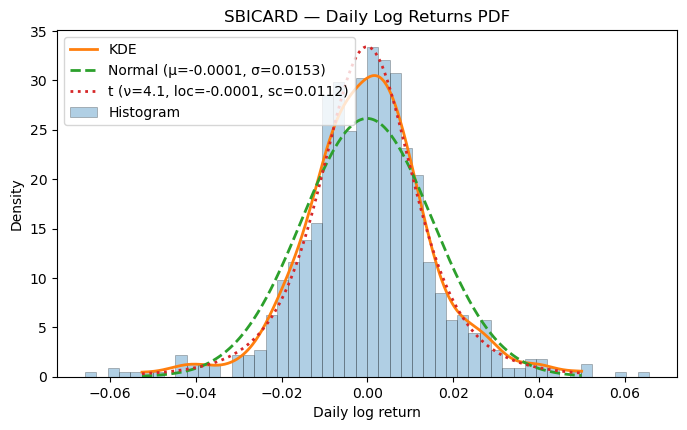

{'symbol': 'SBICARD',
 'n': 855,
 'normal_mu': -6.867450392155233e-05,
 'normal_sigma': 0.015257330895914311,
 'ann_sigma': 0.24220261932726944,
 't_nu': 4.109539024417254,
 't_loc': -7.013387483432743e-05,
 't_scale': 0.01124274655167258}

In [36]:
# If needed:
r_1d = lrets

# Pick a symbol from your columns
sym = r_1d.columns[50]   # or "SBIN", "HDFCBANK", etc.
fit_info = plot_pdf_for_symbol(r_1d, sym, bins=50, use_kde=True, use_t=True)
fit_info


In [37]:
def normal_fit_table(r_1d: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for sym in r_1d.columns:
        x = r_1d[sym].dropna().values
        if len(x) >= 30:
            mu, sigma = fit_normal_params(x)
            rows.append({
                "symbol": sym,
                "n": len(x),
                "mu": mu,
                "sigma": sigma,
                "ann_sigma": sigma * np.sqrt(252),
            })
    return pd.DataFrame(rows).sort_values("ann_sigma", ascending=False)

fit_table = normal_fit_table(r_1d)
fit_table.head(10)


,symbol,n,mu,sigma,ann_sigma
15,BAJFINANCE,855,-0.002379,0.080312,1.274920
38,KELLTONTEC,790,-0.001531,0.061405,0.974778
4,VBL,855,-0.000825,0.046061,0.731204
41,MAZDOCK,855,0.002823,0.042571,0.675798
35,IREDA,442,0.001998,0.035423,0.562322
9,ADANIENT,855,0.000172,0.034004,0.539804
48,RTNPOWER,759,0.001032,0.033970,0.539255
23,DCXINDIA,645,-0.000248,0.033862,0.537542
44,NEWGEN,786,0.000764,0.033779,0.536218
49,RVNL,855,0.002716,0.033645,0.534103


In [38]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import warnings

def min_obs(window, frac=0.80):
    return 1 if window <= 1 else max(1, int(np.ceil(window * frac)))

def rolling_mean_std(df: pd.DataFrame, window: int, frac_ok: float = 0.80):
    minp = min_obs(window, frac_ok)
    m = df.rolling(window, min_periods=minp).mean()
    s = df.rolling(window, min_periods=minp).std(ddof=1)
    return m, s

def zscore_from_df(df: pd.DataFrame, window: int, frac_ok: float = 0.80, eps: float = 1e-12):
    m, s = rolling_mean_std(df, window, frac_ok)
    z = (df - m) / s
    z = z.mask(s < eps)
    return z

def rolling_skew_kurt_safe(df: pd.DataFrame, window: int, frac_ok: float = 0.80):
    import warnings
    minp = max(1, int(np.ceil(window * frac_ok)))
    cnt = df.rolling(window, min_periods=0).count()
    valid = cnt >= minp
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning, message="All-NaN slice encountered")
        skew = df.rolling(window, min_periods=minp).skew()
        kurt = df.rolling(window, min_periods=minp).kurt()
    return skew.where(valid), kurt.where(valid)



In [39]:
def build_normal_plus_moments_table(
    base_df: pd.DataFrame,
    window_days: int,          # e.g., 1, 5, 63, 252 (the *base* horizon)
    z_window: int = None,      # smoothing window for z/skew/kurt (default = window_days)
    min_n: int = 30,           # minimal observations to fit Normal
    frac_ok: float = 0.80,     # data-quality threshold for rolling windows
    annualize_via_252: bool = True,
):
    """
    For each symbol in base_df:
      - Fit Normal to full-sample base series (dropna) -> mu, sigma, n
      - Annualize sigma via sqrt(252/window_days) if annualize_via_252 else sqrt(freq_per_year)
      - Compute latest rolling Z, skew, kurt using z_window (default = window_days)
    Returns a DataFrame sorted by ann_sigma (desc).
    """
    if z_window is None:
        z_window = window_days

    # Rolling diagnostics (latest point per symbol)
    z_df = zscore_from_df(base_df, z_window, frac_ok)
    sk_df, kt_df = rolling_skew_kurt_safe(base_df, z_window, frac_ok)

    # Annualization factor
    if annualize_via_252:
        ann_scale = np.sqrt(252.0 / max(1, window_days))
    else:
        # Alternative: map to calendar frequencies if you prefer (52/4/1)
        # Example (simple): daily->252, weekly->52, quarterly->4, yearly->1
        freq_map = {1: 252.0, 5: 252.0/5.0, 63: 4.0, 252: 1.0}
        ann_scale = np.sqrt(freq_map.get(window_days, 252.0 / max(1, window_days)))

    rows = []
    for sym in base_df.columns:
        x = base_df[sym].dropna().values
        n = len(x)
        if n < min_n:
            continue  # skip thin histories

        mu, sigma = norm.fit(x)
        ann_sigma = sigma * ann_scale

        # Latest available Z / skew / kurt
        z_last   = z_df[sym].dropna().iloc[-1]  if sym in z_df  and z_df[sym].notna().any() else np.nan
        skew_last= sk_df[sym].dropna().iloc[-1] if sym in sk_df and sk_df[sym].notna().any() else np.nan
        kurt_last= kt_df[sym].dropna().iloc[-1] if sym in kt_df and kt_df[sym].notna().any() else np.nan

        rows.append({
            "symbol": sym,
            "n": n,
            "mu": mu,
            "sigma": sigma,
            "ann_sigma": ann_sigma,
            f"z_last_w{z_window}": z_last,
            f"skew_last_w{z_window}": skew_last,
            f"kurt_last_w{z_window}": kurt_last,
        })

    out = pd.DataFrame(rows).sort_values("ann_sigma", ascending=False).reset_index(drop=True)
    return out


In [40]:
# You already have r_1w from earlier: r_1w = trailing_log_returns(lrets, 5)

weekly_table = build_normal_plus_moments_table(
    base_df=r_1m,
    window_days=252,    # base horizon is 1w = 5 trading days
    z_window=63,       # use same window for z/skew/kurt (feel free to change to 21 etc.)
    min_n=30,
    frac_ok=0.80,
)

display(weekly_table.head(60))


,symbol,n,mu,sigma,ann_sigma,z_last_w63,skew_last_w63,kurt_last_w63
0,BAJFINANCE,839,-0.052429,0.368931,0.368931,0.785523,-0.720517,-1.523499
1,KELLTONTEC,762,-0.030552,0.297605,0.297605,0.643471,-0.712124,-1.489762
2,MAZDOCK,839,0.056575,0.217731,0.217731,0.667494,-0.085722,-0.048924
3,VBL,839,-0.017075,0.208961,0.208961,-1.056571,0.400016,-1.156585
4,IREDA,426,0.029997,0.194397,0.194397,1.322921,0.127340,0.600973
5,RVNL,839,0.056514,0.179368,0.179368,0.542932,1.421531,3.957252
6,ADANIENT,839,0.001948,0.163715,0.163715,0.875994,-0.285305,-1.208779
7,HAL,839,0.026087,0.159545,0.159545,0.417984,0.424359,1.000931
8,RTNPOWER,700,0.011787,0.158442,0.158442,-0.084747,-0.019736,-1.328449
9,NEWGEN,758,0.022566,0.155700,0.155700,0.671005,-0.220943,-0.898791


In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, t, gaussian_kde

def _fit_normal(x):
    mu, sigma = norm.fit(x)    # MLE
    return mu, sigma

def _fit_t(x):
    try:
        nu, loc, scale = t.fit(x)
    except Exception:
        loc, scale = np.mean(x), np.std(x, ddof=1); nu = 1000.0
    return nu, loc, scale

def _auto_bins(x, max_bins=80):
    # Freedman–Diaconis rule, with an upper cap to avoid over-binning
    x = np.asarray(x)
    q25, q75 = np.percentile(x, [25, 75])
    iqr = q75 - q25
    if iqr <= 0:
        return min(50, max_bins)
    h = 2 * iqr / (len(x) ** (1/3))
    if h <= 0:
        return min(50, max_bins)
    k = int(np.ceil((x.max() - x.min()) / h))
    return int(np.clip(k, 20, max_bins))

def _draw_pdf_panel(ax, series, title, bins=None, clip=(0.5, 99.5)):
    """Draw one panel: hist+KDE + Normal & t fits + ±1σ/±2σ lines + skew/kurt textbox."""
    x = series.dropna().values
    if x.size < 30:
        ax.set_title(f"{title} (insufficient data: n={x.size})")
        ax.axis("off")
        return

    # Empirical moments
    mu_emp = np.nanmean(x)
    sigma_emp = np.nanstd(x, ddof=1)
    skew_emp = pd.Series(x).skew()
    kurt_emp = pd.Series(x).kurt()

    # Fit Normal & t
    mu_hat, sigma_hat = _fit_normal(x)
    nu_hat, loc_hat, scale_hat = _fit_t(x)

    # Grid for smooth curves (focus on central mass)
    lo, hi = np.percentile(x, clip)
    grid = np.linspace(lo, hi, 500)

    # PDFs
    kde_pdf = gaussian_kde(x)(grid)
    normal_pdf = norm.pdf(grid, mu_hat, sigma_hat)
    t_pdf = t.pdf(grid, df=nu_hat, loc=loc_hat, scale=scale_hat)

    # Histogram
    if bins is None:
        bins = _auto_bins(x)
    ax.hist(x, bins=bins, density=True, alpha=0.35, edgecolor="black", linewidth=0.5, label="Hist")

    # Curves
    ax.plot(grid, kde_pdf, linewidth=2, label="KDE")
    ax.plot(grid, normal_pdf, linewidth=2, linestyle="--", label=f"Normal (μ={mu_hat:.4f}, σ={sigma_hat:.4f})")
    ax.plot(grid, t_pdf, linewidth=2, linestyle=":", label=f"t (ν={nu_hat:.1f})")

    # ±1σ / ±2σ (use empirical μ, σ)
    for k, ls in [(1, (0, (4,4))), (2, (0, (2,3)))]:
        ax.axvline(mu_emp + k*sigma_emp, linestyle=ls, linewidth=1.5)
        ax.axvline(mu_emp - k*sigma_emp, linestyle=ls, linewidth=1.5)

    # Mean line (solid)
    ax.axvline(mu_emp, color="black", linewidth=1.2)

    # Labels/legend
    ax.set_title(title)
    ax.set_xlabel("Log return")
    ax.set_ylabel("Density")
    ax.legend(loc="upper left", fontsize=9)

    # Skew/kurt textbox
    txt = f"n={x.size}\nμ(emp)={mu_emp:.4f}\nσ(emp)={sigma_emp:.4f}\nskew={skew_emp:.3f}\nkurt={kurt_emp:.3f}"
    ax.text(0.98, 0.98, txt, transform=ax.transAxes, va="top", ha="right",
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8), fontsize=9)


In [42]:
def plot_multi_timeframe_pdfs(symbol: str,
                              r1d: pd.DataFrame,
                              r1m: pd.DataFrame,
                              r1q: pd.DataFrame,
                              r1y: pd.DataFrame):
    """
    2×2 figure: Daily / Monthly(21d) / Quarterly(63d) / Yearly(252d) PDFs for `symbol`.
    Uses empirical σ for ±1σ/±2σ guides. KDE + Normal + Student-t overlays.
    """
    if symbol not in r1d.columns:
        raise KeyError(f"{symbol} not found in returns columns.")

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()

    _draw_pdf_panel(axes[0], r1d[symbol], f"{symbol} — Daily (1d)")
    _draw_pdf_panel(axes[1], r1m[symbol], f"{symbol} — Monthly (21d)")
    _draw_pdf_panel(axes[2], r1q[symbol], f"{symbol} — Quarterly (63d)")
    _draw_pdf_panel(axes[3], r1y[symbol], f"{symbol} — Yearly (252d)")

    plt.tight_layout()
    plt.show()


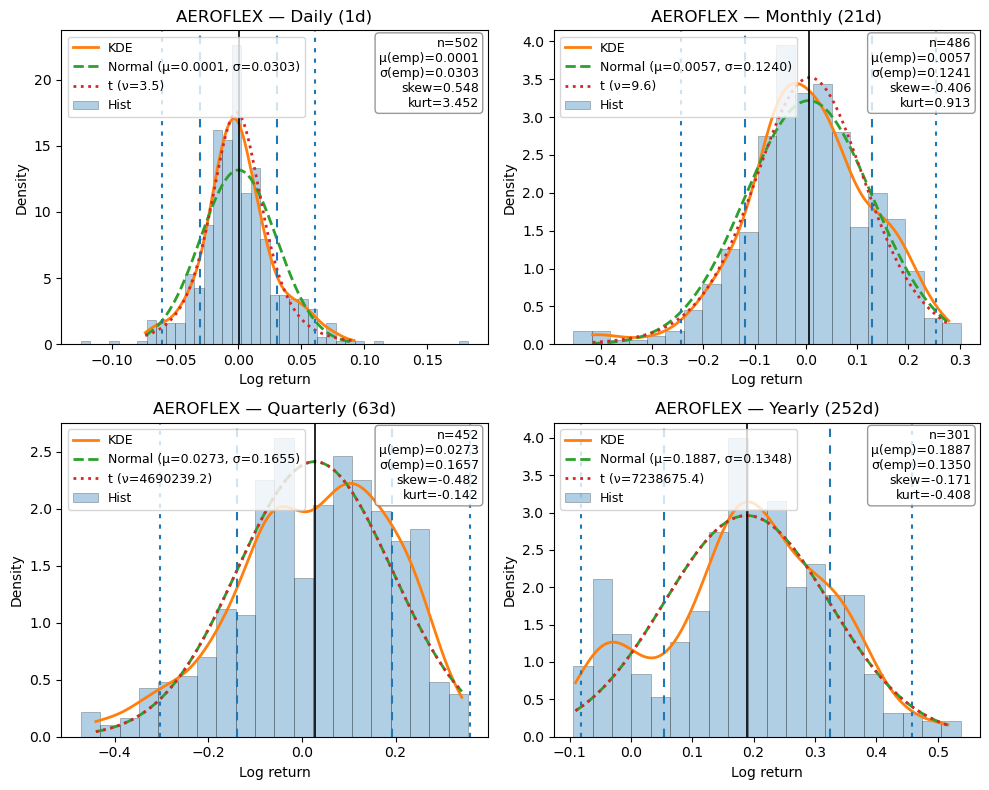

In [43]:
plot_multi_timeframe_pdfs("AEROFLEX", r_1d, r_1m, r_1q, r_1y)

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, t, gaussian_kde

def _fit_normal(x):
    mu, sigma = norm.fit(x)
    return mu, sigma

def _fit_t(x):
    try:
        nu, loc, scale = t.fit(x)
    except Exception:
        loc, scale = np.mean(x), np.std(x, ddof=1); nu = 1000.0
    return nu, loc, scale

def _quantile_grid(xs, qlo=0.5, qhi=99.5, n=600):
    """Common x-grid from pooled data percentiles."""
    allx = np.concatenate(xs) if len(xs) else np.array([])
    lo, hi = np.percentile(allx, [qlo, qhi])
    return np.linspace(lo, hi, n)

def plot_multi_tf_overlay(symbol: str,
                          r1d: pd.DataFrame, r1m: pd.DataFrame, r1q: pd.DataFrame, r1y: pd.DataFrame,
                          show=('normal')):
    """
    One-axes overlay of PDFs for a single stock across multiple horizons:
    - daily (1d), monthly (21d), quarterly (63d), yearly (252d)
    - KDE + optional Normal & Student-t fits
    - color-coded ±1σ and ±2σ vertical guides per timeframe (empirical μ, σ)
    """
    if symbol not in r1d.columns:
        raise KeyError(f"{symbol} not found in returns columns.")

    # Collect series per timeframe
    series_map = {
        "1d":   r1d[symbol].dropna(),
        "21d":  r1m[symbol].dropna(),
        "63d":  r1q[symbol].dropna(),
        "252d": r1y[symbol].dropna(),
    }
    # Filter out timeframes with insufficient data
    series_map = {k: v for k, v in series_map.items() if v.size >= 30}
    if not series_map:
        raise ValueError("Not enough data in any timeframe (need ≥30 points).")

    # Common x-grid across all series (focus on central mass)
    grid = _quantile_grid([v.values for v in series_map.values()], 0.5, 99.5, n=600)

    fig, ax = plt.subplots(figsize=(10, 6))

    for tf_name, s in series_map.items():
        x = s.values

        # Empirical stats for guides/legend
        mu_emp   = np.nanmean(x)
        sigma_emp= np.nanstd(x, ddof=1)
        skew_emp = pd.Series(x).skew()
        kurt_emp = pd.Series(x).kurt()

        # Fit models
        mu_hat, sigma_hat = _fit_normal(x)
        nu_hat, loc_hat, scale_hat = _fit_t(x)

        # Primary curve: KDE (gets the legend)
        kde_pdf = gaussian_kde(x)(grid)
        [kde_line] = ax.plot(grid, kde_pdf, linewidth=2,
                             label=f"{tf_name}  μ={mu_emp:.4f}  σ={sigma_emp:.4f}  skew={skew_emp:.2f}  kurt={kurt_emp:.2f}")
        color = kde_line.get_color()

        # Optional fits (lighter)
        if 'normal' in show:
            ax.plot(grid, norm.pdf(grid, mu_hat, sigma_hat), linestyle='--', linewidth=1.5, alpha=0.7, color=color)
        if 't' in show:
            ax.plot(grid, t.pdf(grid, df=nu_hat, loc=loc_hat, scale=scale_hat), linestyle=':', linewidth=1.5, alpha=0.8, color=color)

        # ±1σ / ±2σ guides (empirical, color-coded, faint)
        for k, ls in [(1, (0, (4,4))), (2, (0, (2,3)))]:
            ax.axvline(mu_emp + k*sigma_emp, color=color, alpha=0.25, linewidth=1.2, linestyle=ls)
            ax.axvline(mu_emp - k*sigma_emp, color=color, alpha=0.25, linewidth=1.2, linestyle=ls)

        # Mean line (thin)
        ax.axvline(mu_emp, color=color, alpha=0.3, linewidth=0.9)

    ax.set_title(f"{symbol} — Multi-timeframe PDFs (KDE + Normal/t overlays)")
    ax.set_xlabel("Log return")
    ax.set_ylabel("Density")
    ax.legend(loc="upper left", fontsize=9)
    plt.tight_layout()
    plt.show()


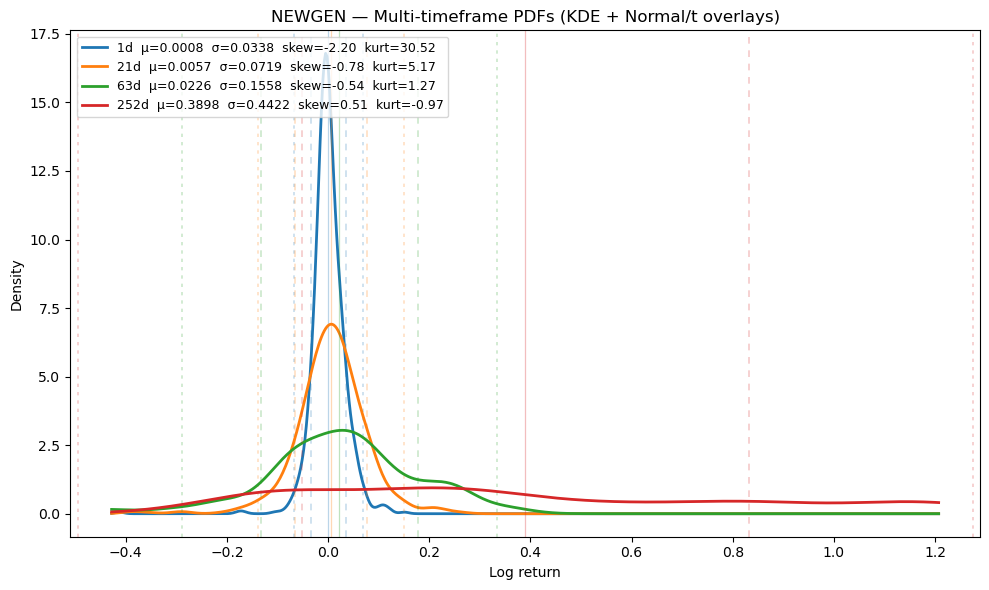

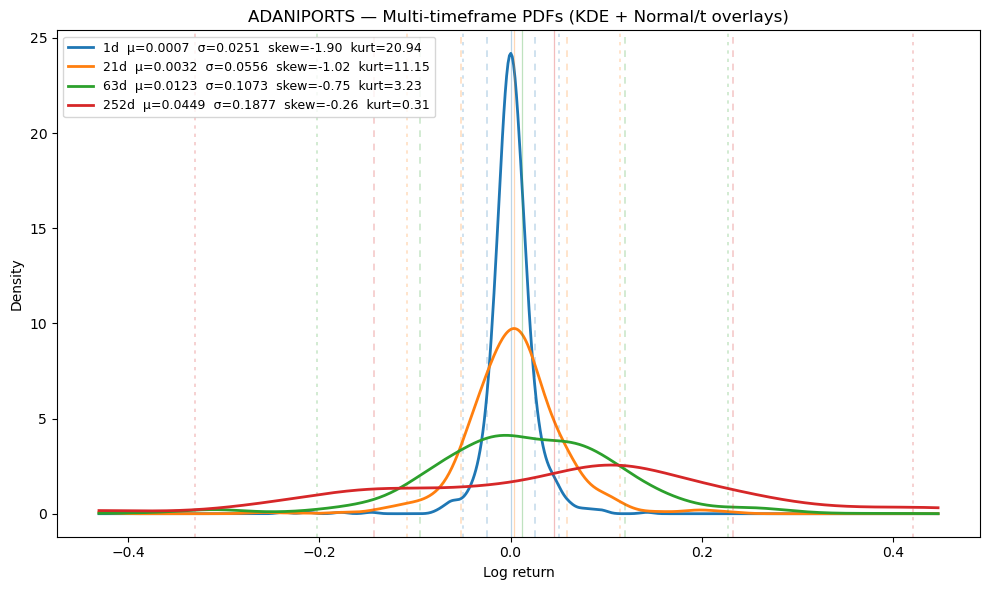

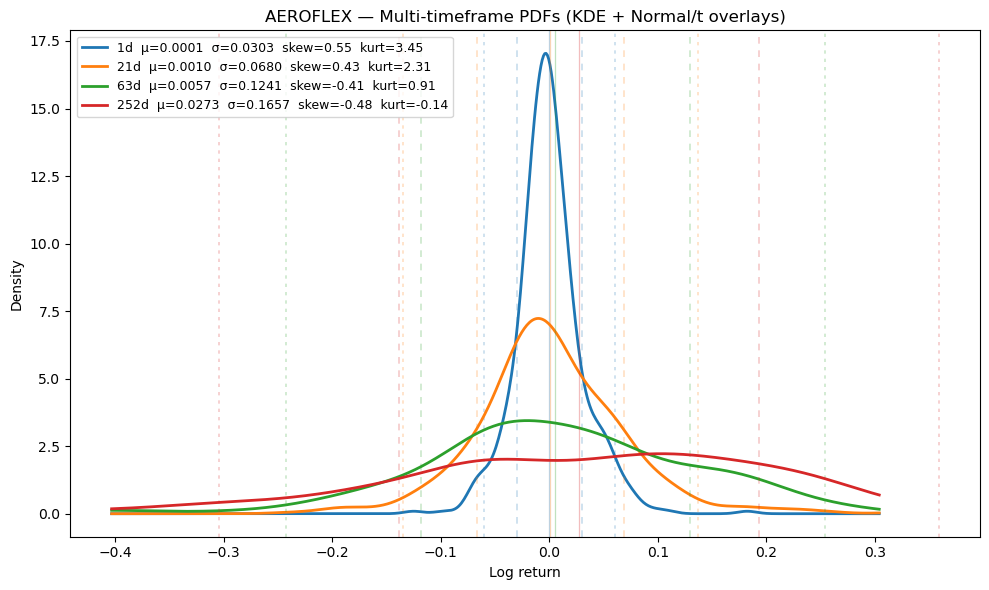

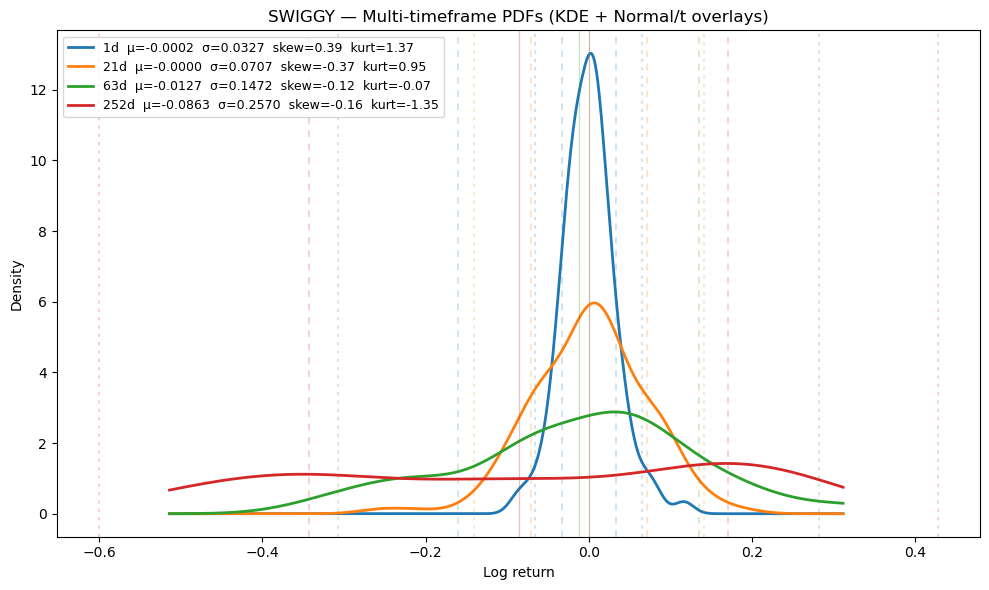

In [45]:
# EXAMPLE:


plot_multi_tf_overlay("NEWGEN", r_1d, r_1w, r_1m, r_1y, r_1y)
plot_multi_tf_overlay("ADANIPORTS", r_1d, r_1w, r_1m, r_1q, r_1y)
plot_multi_tf_overlay("AEROFLEX", r_1d, r_1w, r_1m, r_1q, r_1y)
plot_multi_tf_overlay("SWIGGY", r_1d, r_1w, r_1m, r_1q, r_1y)


In [46]:
# Pairwise Correlation - Betas

In [47]:
def pairwise_corr(df: pd.DataFrame, min_obs: int = 126) -> pd.DataFrame:
    """
    Full-sample pairwise correlation with a minimum overlap per pair.
    df: wide DataFrame of returns (rows: dates, cols: symbols)
    min_obs: require at least this many overlapping (non-NaN) points for each pair
    """
    # 1) Build a 0/1 mask of where each asset has data (1) vs NaN (0).
    valid = df.notna().astype(int)

    # 2) Compute pairwise overlap counts via matrix multiply:
    #    nxy[i,j] = sum over time of (valid_i * valid_j)
    #    This works because (valid.T @ valid)[i,j] is the dot product of 0/1 columns i and j.
    nxy = valid.T @ valid

    # 3) Compute Pearson correlations, letting pandas use pairwise complete cases.
    #    'min_periods=min_obs' ensures pandas won't compute corr for pairs with fewer than min_obs overlaps.
    corr = df.corr(min_periods=min_obs)

    # 4) Extra guard: even if pandas produced a number, blank out entries whose overlap is < min_obs.
    #    (Redundant with step 3, but keeps intent explicit and robust if defaults change.)
    corr = corr.where(nxy >= min_obs)

    return corr


In [48]:
corr_full_1d = pairwise_corr(r_1d, min_obs=126)
corr_full_1d.to_pickle(r"C:\Users\quantbase\Desktop\quant\data_int\corr_full_1d.pkl")
corr_full_1d.iloc[:5, :5]

,ACI,TATAELXSI,TATAPOWER,UJJIVANSFB,VBL
ACI,1.000000,0.074937,0.206518,0.174296,0.060253
TATAELXSI,0.074937,1.000000,0.361489,0.263191,0.063953
TATAPOWER,0.206518,0.361489,1.000000,0.368693,0.112600
UJJIVANSFB,0.174296,0.263191,0.368693,1.000000,0.107464
VBL,0.060253,0.063953,0.112600,0.107464,1.000000


In [49]:
# B) Rolling correlation matrices

In [50]:
def rolling_corr_mats(df: pd.DataFrame, window: int = 63, min_frac: float = 0.80):
    """
    Return a dict mapping window-end dates -> correlation matrix for that window.
    - df: wide returns (dates x symbols)
    - window: rolling window length (e.g., 63 for ~1 quarter)
    - min_frac: require at least this fraction of non-NaN points per series within the window
    """
    # 1) Convert the fraction into an integer 'min_periods' (e.g., 0.8 * 63 ≈ 50).
    minp = max(1, int(np.ceil(window * min_frac)))

    # 2) Ask pandas for rolling correlations. This returns a 3D-like object:
    #    index is a MultiIndex (date, symbol_row); columns are symbol_col.
    #    For each date t, rc.loc[t] is the correlation matrix at t over the preceding 'window' days.
    rc = df.rolling(window, min_periods=minp).corr()

    out = {}
    # 3) Iterate over feasible window-end dates (start where a full-length window could exist).
    for dt in df.index[window-1:]:
        try:
            # 3a) Extract the correlation matrix for date dt.
            mat = rc.loc[dt]

            # 3b) Some symbols may be all-NaN within that window.
            #     Drop rows/cols that are entirely NaN so the matrix is valid.
            keep = mat.notna().any(axis=1)
            mat = mat.loc[keep, keep]

            # 3c) Only store matrices with at least 2 assets (corr of 1 asset is degenerate).
            if mat.shape[0] >= 2:
                out[dt] = mat
        except KeyError:
            # If rc has no entry for dt (rare due to NaNs), just skip.
            continue

    return out


In [51]:
roll_corr_63 = rolling_corr_mats(r_1d, window=63, min_frac=0.80)
roll_corr_252 = rolling_corr_mats(r_1d, window=252, min_frac=0.80)

# Save as pickles (dict of date->DataFrame)
import pickle, os
base = r"C:\Users\quantbase\Desktop\quant\data_int"
pickle.dump(roll_corr_63,  open(os.path.join(base, "corr_roll_63.pkl"), "wb"))
pickle.dump(roll_corr_252, open(os.path.join(base, "corr_roll_252.pkl"), "wb"))

In [52]:
def beta_full(r_assets: pd.DataFrame, r_index: pd.Series, min_obs: int = 126) -> pd.Series:
    """
    Compute full-sample β for each asset relative to 'r_index'.
    β = Cov(asset, index) / Var(index), using overlapping non-NaN pairs only.
    """
    out = {}
    for sym in r_assets.columns:
        # 1) Align the asset and index by date, and drop any rows where either is NaN.
        xy = pd.concat([r_assets[sym], r_index], axis=1).dropna()

        # 2) Require a minimum number of overlapping points and a nonzero index variance.
        if len(xy) >= min_obs and np.var(xy.iloc[:,1], ddof=1) > 0:
            # 3) Sample covariance and variance with ddof=1 (unbiased sample estimators).
            cov = np.cov(xy.iloc[:,0], xy.iloc[:,1], ddof=1)[0,1]
            var = np.var(xy.iloc[:,1], ddof=1)

            # 4) β is the slope of stock on index in a simple OLS with zero-centered data.
            out[sym] = cov / var
        else:
            out[sym] = np.nan

    return pd.Series(out, name="beta_full")


In [53]:
def beta_rolling(r_assets: pd.DataFrame, r_index: pd.Series,
                 window: int = 252, min_frac: float = 0.80) -> pd.DataFrame:
    """
    Rolling β per asset:
    β_t = Cov_t(asset, index) / Var_t(index), computed over the last 'window' days,
    requiring at least 'min_frac' of observations in the window.
    Returns: DataFrame (dates x symbols) with β_t for each symbol.
    """
    # 1) Convert fraction to a concrete min_periods integer.
    minp = max(1, int(np.ceil(window * min_frac)))

    out = []
    for sym in r_assets.columns:
        # 2) Align asset and index returns and drop dates where either is NaN.
        xy = pd.concat([r_assets[sym], r_index], axis=1).dropna()
        if xy.empty:
            out.append(pd.Series(dtype=float, name=sym))
            continue

        # 3) Rolling covariance between stock and index over the window.
        #    Using pandas' Series.rolling(...).cov(other_series) computes pairwise covariances across windowed pairs.
        cov_si = xy.iloc[:,0].rolling(window, min_periods=minp).cov(xy.iloc[:,1])

        # 4) Rolling variance of the index over the same window.
        var_i  = xy.iloc[:,1].rolling(window, min_periods=minp).var()

        # 5) Rolling β is the ratio; name the series so concatenation keeps symbol labels.
        beta_s = (cov_si / var_i).rename(sym)

        out.append(beta_s)

    # 6) Assemble all symbol series column-wise and reindex to the original asset index (full date index).
    beta_df = pd.concat(out, axis=1).reindex(r_assets.index)
    return beta_df


In [54]:
# === Correlation & Beta — One-Cell Runner ====================================
# Uses: pandas 1.2.x / numpy / standard libs
import os, pickle
import numpy as np
import pandas as pd
from pathlib import Path

# ---- Paths (edit if needed) -------------------------------------------------
DATA_INT = Path(r"C:\Users\quantbase\Desktop\quant\data_int")
DATA_RAW = Path(r"C:\Users\quantbase\Desktop\quant\data_raw")
INDEX_CSV = DATA_RAW / "BAJFINANCE.csv"  # <-- put your index CSV here (expects DATE,CLOSE)

DATA_INT.mkdir(parents=True, exist_ok=True)

# ---- Load prices (Close matrix) & build daily log returns -------------------
def _load_prices_close_matrix():
    """Load Close panel from pickle (fast); fallback to CSV if pkl not present."""
    pkl = DATA_INT / "prices_close_anchor_leftjoin.pkl"
    csv = DATA_INT / "prices_close_anchor_leftjoin.csv"
    if pkl.exists():
        return pd.read_pickle(pkl)
    elif csv.exists():
        df = pd.read_csv(csv, parse_dates=[0], index_col=0)
        # ensure numeric
        df = df.apply(pd.to_numeric, errors="coerce")
        return df
    else:
        raise FileNotFoundError("Could not find prices_close_anchor_leftjoin.(pkl|csv) in data_int/.")

def _compute_daily_log_returns(prices_df: pd.DataFrame) -> pd.DataFrame:
    """
    Gap-aware daily log returns:
    - Uses simple diff of log prices (so any day touching NaN stays NaN),
    - preserves NaNs for pre-IPO / non-trading gaps.
    """
    logp = np.log(prices_df)
    lrets = logp.diff()
    return lrets

prices_close = _load_prices_close_matrix().sort_index()
r_1d = _compute_daily_log_returns(prices_close)

# Optional: save daily returns for reuse
r_1d_path = DATA_INT / "log_returns_daily.pkl"
r_1d.to_pickle(r_1d_path)

# ---- Load index close & returns ---------------------------------------------
def _load_index_close(csv_path: Path) -> pd.Series:
    if not csv_path.exists():
        raise FileNotFoundError(f"Index CSV not found at: {csv_path}")
    df = pd.read_csv(csv_path, usecols=["DATE","CLOSE"])
    df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")
    df = df.dropna(subset=["DATE"]).sort_values("DATE")
    s = df.set_index("DATE")["CLOSE"].astype(float)
    s = s.where(s > 0)
    s.name = csv_path.stem.upper()
    return s

idx_close = _load_index_close(INDEX_CSV)
idx_ret = np.log(idx_close).diff()
# align index returns to the same calendar as r_1d
idx_ret = idx_ret.reindex(r_1d.index)

# ---- A) Pairwise correlation (full sample, daily) ---------------------------
def pairwise_corr(df: pd.DataFrame, min_obs: int = 126) -> pd.DataFrame:
    """
    Full-sample pairwise correlation with a minimum overlap per pair.
    - df: wide returns (dates x symbols)
    - min_obs: minimum overlapping non-NaN observations required for each pair
    """
    # 0/1 presence mask
    valid = df.notna().astype(int)
    # pairwise overlap counts via dot-product of presence columns
    nxy = valid.T @ valid
    # Pearson correlations with a min_obs guard
    corr = df.corr(min_periods=min_obs)
    # extra mask for robustness
    return corr.where(nxy >= min_obs)

corr_full_1d = pairwise_corr(r_1d, min_obs=126)
corr_full_1d.to_pickle(DATA_INT / "corr_full_1d.pkl")

# ---- B) Rolling correlation matrices (dict of date -> corr-matrix) ----------
def rolling_corr_mats(df: pd.DataFrame, window: int = 63, min_frac: float = 0.80):
    """
    Dict[date -> corr-matrix] for each window end:
    - df: wide returns (dates x symbols)
    - window: rolling window length (e.g., 63 ~ 1 quarter)
    - min_frac: require at least this fraction of observations per series within the window
    """
    minp = max(1, int(np.ceil(window * min_frac)))
    rc = df.rolling(window, min_periods=minp).corr()
    out = {}
    for dt in df.index[window-1:]:
        try:
            mat = rc.loc[dt]
            keep = mat.notna().any(axis=1)
            mat = mat.loc[keep, keep]
            if mat.shape[0] >= 2:
                out[dt] = mat
        except KeyError:
            continue
    return out

roll_corr_63 = rolling_corr_mats(r_1d, window=63, min_frac=0.80)
with open(DATA_INT / "corr_roll_63.pkl", "wb") as f:
    pickle.dump(roll_corr_63, f)

# ---- C) Full-sample beta: β = Cov(stock, index) / Var(index) ----------------
def beta_full(r_assets: pd.DataFrame, r_index: pd.Series, min_obs: int = 126) -> pd.Series:
    """
    Full-sample β(stock←index) per asset using overlapping, non-NaN dates.
    """
    out = {}
    for sym in r_assets.columns:
        xy = pd.concat([r_assets[sym], r_index], axis=1).dropna()
        if len(xy) >= min_obs and np.var(xy.iloc[:,1], ddof=1) > 0:
            cov = np.cov(xy.iloc[:,0], xy.iloc[:,1], ddof=1)[0,1]
            var = np.var(xy.iloc[:,1], ddof=1)
            out[sym] = cov / var
        else:
            out[sym] = np.nan
    return pd.Series(out, name="beta_full")

beta_full_1d = beta_full(r_1d, idx_ret, min_obs=126)
beta_full_1d.to_csv(DATA_INT / "beta_full_1d.csv")

# ---- D) Rolling beta over 252d (≈ 1y) ---------------------------------------
def beta_rolling(r_assets: pd.DataFrame, r_index: pd.Series,
                 window: int = 252, min_frac: float = 0.80) -> pd.DataFrame:
    """
    Rolling β(stock←index) per asset:
    - window: lookback length (e.g., 252)
    - min_frac: minimum fraction of non-NaN observations in the window
    """
    minp = max(1, int(np.ceil(window * min_frac)))
    out = []
    for sym in r_assets.columns:
        xy = pd.concat([r_assets[sym], r_index], axis=1).dropna()
        if xy.empty:
            out.append(pd.Series(dtype=float, name=sym))
            continue
        cov_si = xy.iloc[:,0].rolling(window, min_periods=minp).cov(xy.iloc[:,1])
        var_i  = xy.iloc[:,1].rolling(window, min_periods=minp).var()
        beta_s = (cov_si / var_i).rename(sym)
        out.append(beta_s)
    beta_df = pd.concat(out, axis=1).reindex(r_assets.index)
    return beta_df

beta_roll_252 = beta_rolling(r_1d, idx_ret, window=252, min_frac=0.80)
beta_roll_252.to_pickle(DATA_INT / "beta_roll_252.pkl")

# ---- Summary printout -------------------------------------------------------
def _avg_abs_offdiag(mat: pd.DataFrame) -> float:
    if mat.empty: return np.nan
    a = np.abs(mat.values)
    mask = np.triu(np.ones(a.shape, dtype=bool), k=1)
    vals = a[mask]
    vals = vals[~np.isnan(vals)]
    return float(vals.mean()) if vals.size else np.nan

print("\n=== SUMMARY ===")
print(f"Daily returns saved to: {r_1d_path.name}")
print(f"Full-sample corr matrix: corr_full_1d.pkl  | shape: {corr_full_1d.shape}")
print(f"Avg |corr| (upper-tri):  {_avg_abs_offdiag(corr_full_1d):.3f}")

# Top / bottom 5 beta (full sample)
betas_sorted = beta_full_1d.sort_values(na_position='last')
print("\nTop 5 β (highest):")
print(betas_sorted.tail(5))
print("\nBottom 5 β (lowest):")
print(betas_sorted.head(5))

# Rolling corr snapshot
if len(roll_corr_63):
    last_dt = sorted(roll_corr_63.keys())[-1]
    print(f"\nRolling corr (63d): {len(roll_corr_63)} windows | last date {last_dt.date()} | "
          f"last matrix shape {roll_corr_63[last_dt].shape}")
else:
    print("\nRolling corr (63d): no windows produced (insufficient data?)")

# Rolling beta snapshot
last_row = beta_roll_252.dropna(how="all").tail(1)
if not last_row.empty:
    last_dt = last_row.index[-1]
    n_valid = int(last_row.notna().sum(axis=1).iloc[-1])
    print(f"Rolling β (252d): last date {last_dt.date()} | symbols with β: {n_valid}/{beta_roll_252.shape[1]}")
else:
    print("Rolling β (252d): no valid rows yet (need more data for the window)")



=== SUMMARY ===
Daily returns saved to: log_returns_daily.pkl
Full-sample corr matrix: corr_full_1d.pkl  | shape: (57, 57)
Avg |corr| (upper-tri):  0.231

Top 5 β (highest):
ADANIPORTS    0.024081
HFCL          0.031170
KELLTONTEC    0.031514
BAJFINANCE    1.000000
WAAREERTL          NaN
Name: beta_full, dtype: float64

Bottom 5 β (lowest):
PRINCEPIPE   -0.012849
NEWGEN       -0.011804
SWIGGY       -0.004144
PREMIERENE   -0.002738
INDIGO        0.002343
Name: beta_full, dtype: float64

Rolling corr (63d): 794 windows | last date 2025-09-09 | last matrix shape (57, 57)
Rolling β (252d): last date 2025-09-09 | symbols with β: 56/57


In [55]:
# === Correlation Heatmap for All Stocks ======================================
import os, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, leaves_list

# ---- Paths ------------------------------------------------------------------
DATA_INT = Path(r"C:\Users\quantbase\Desktop\quant\data_int")
FIG_DIR  = Path(r"C:\Users\quantbase\Desktop\quant\figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

# ---- Load daily returns (or compute if you prefer) --------------------------
r_1d_path = DATA_INT / "log_returns_daily.pkl"
if not r_1d_path.exists():
    raise FileNotFoundError("Expected daily returns at data_int/log_returns_daily.pkl — run returns step first.")
r_1d = pd.read_pickle(r_1d_path).sort_index()

# ---- 1) Correlation with min-overlap guard ----------------------------------
def pairwise_corr(df: pd.DataFrame, min_obs: int = 126) -> pd.DataFrame:
    """
    Full-sample Pearson correlation with a minimum overlap per pair.
    df: wide returns (dates x symbols)
    min_obs: require at least this many overlapping non-NaN points for each pair
    """
    valid = df.notna().astype(int)        # 0/1 mask of data presence
    nxy   = valid.T @ valid               # pairwise overlap counts
    corr  = df.corr(min_periods=min_obs)  # pandas computes with pairwise complete obs
    return corr.where(nxy >= min_obs)     # blank out pairs with too little overlap

corr = pairwise_corr(r_1d, min_obs=126)

# ---- 2) Optional: cluster symbols to group similar names --------------------
def cluster_order_from_corr(corr_df: pd.DataFrame) -> list:
    """
    Return an order of symbols by hierarchical clustering on (1 - corr).
    NaNs are treated as distance=1.0 (maximally far).
    """
    c = corr_df.copy()
    # fill NaNs (no overlap) as zero corr so distance = 1 - 0 = 1
    c = c.fillna(0.0)
    np.fill_diagonal(c.values, 1.0)
    dist = 1.0 - c.values
    # condensed distance for linkage
    dist_condensed = squareform(dist, checks=False)
    Z = linkage(dist_condensed, method="average")
    order_idx = leaves_list(Z)
    return list(corr_df.index[order_idx])

# Choose whether to cluster
DO_CLUSTER = True
if DO_CLUSTER and corr.shape[0] >= 3:
    ordered_syms = cluster_order_from_corr(corr)
    corr = corr.loc[ordered_syms, ordered_syms]

# ---- 3) Plot heatmap (matplotlib only) --------------------------------------
def plot_corr_heatmap(corr_df: pd.DataFrame,
                      title: str = "Pairwise correlation (daily returns)",
                      save_path: Path = None,
                      annotate_if_small: bool = True):
    """
    Matplotlib heatmap:
      - diverging colormap centered at 0, range [-1, 1]
      - NaNs shown as light gray
      - optional numeric annotation if matrix is small (<= 30 x 30)
    """
    if corr_df.empty:
        raise ValueError("Correlation matrix is empty.")

    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap

    # mask NaNs so they render with 'bad' color
    A = np.ma.masked_invalid(corr_df.values)

    # Build a copy of RdBu_r that's safe to mutate (matplotlib 3.3.x compatible)
    base = plt.cm.get_cmap('RdBu_r')
    cmap = ListedColormap(base(np.linspace(0, 1, base.N)))
    cmap.set_bad(color="#f0f0f0")  # light gray for NaNs

    n = corr_df.shape[0]
    fig, ax = plt.subplots(figsize=(min(16, max(8, n * 0.25)), min(12, max(6, n * 0.25))))

    im = ax.imshow(A, vmin=-1, vmax=1, cmap=cmap, interpolation="nearest")
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Correlation (ρ)")

    ax.set_title(title, pad=12)
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels(corr_df.columns, rotation=90, fontsize=8)
    ax.set_yticklabels(corr_df.index, fontsize=8)

    # grid lines between cells
    ax.set_xticks(np.arange(-0.5, n, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, n, 1), minor=True)
    ax.grid(which="minor", color="white", linestyle="-", linewidth=0.5)
    ax.tick_params(which="minor", bottom=False, left=False)

    # annotate numbers if matrix is not too large
    if annotate_if_small and n <= 30:
        for i in range(n):
            for j in range(n):
                val = corr_df.iat[i, j]
                if not np.isnan(val):
                    ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=7)

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"Saved heatmap → {save_path}")
    plt.show()




Saved heatmap → C:\Users\quantbase\Desktop\quant\figures\corr_heatmap_daily.png


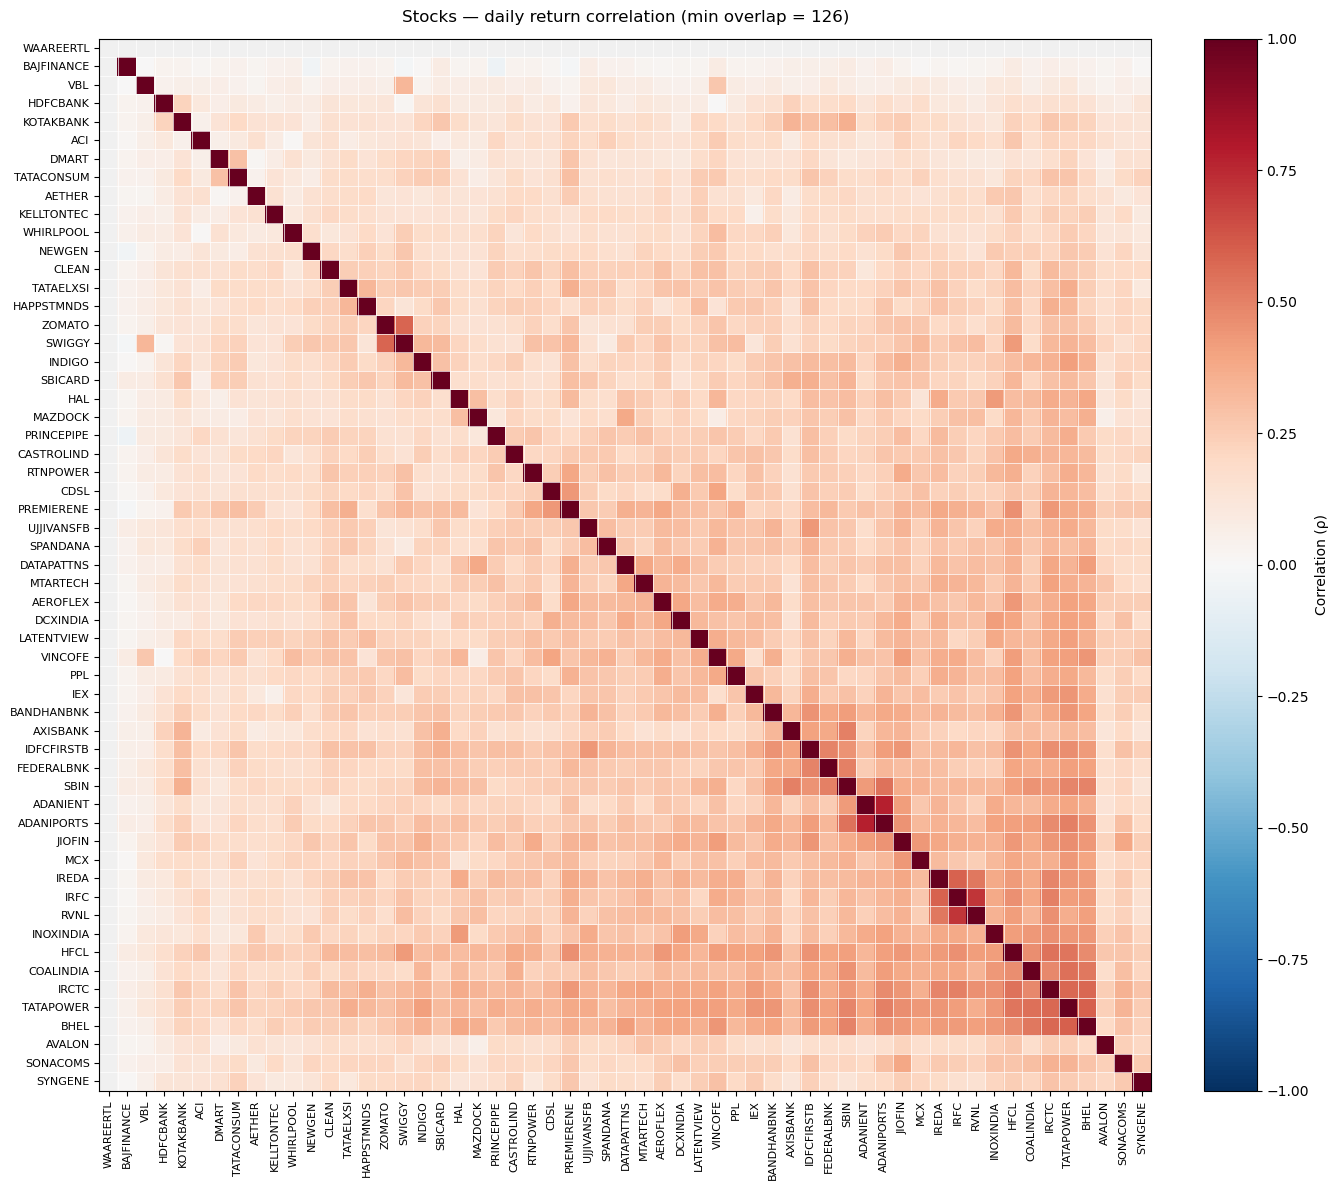

In [56]:
# ---- 4) Call plotter & save --------------------------------------------------
plot_corr_heatmap(
    corr,
    title="Stocks — daily return correlation (min overlap = 126)",
    save_path=FIG_DIR / "corr_heatmap_daily.png",
    annotate_if_small=False  # turn on only if you subset to <= 30 symbols
)

Saved heatmap → C:\Users\quantbase\Desktop\quant\figures\corr_heatmap_63d_2025-09-09.png


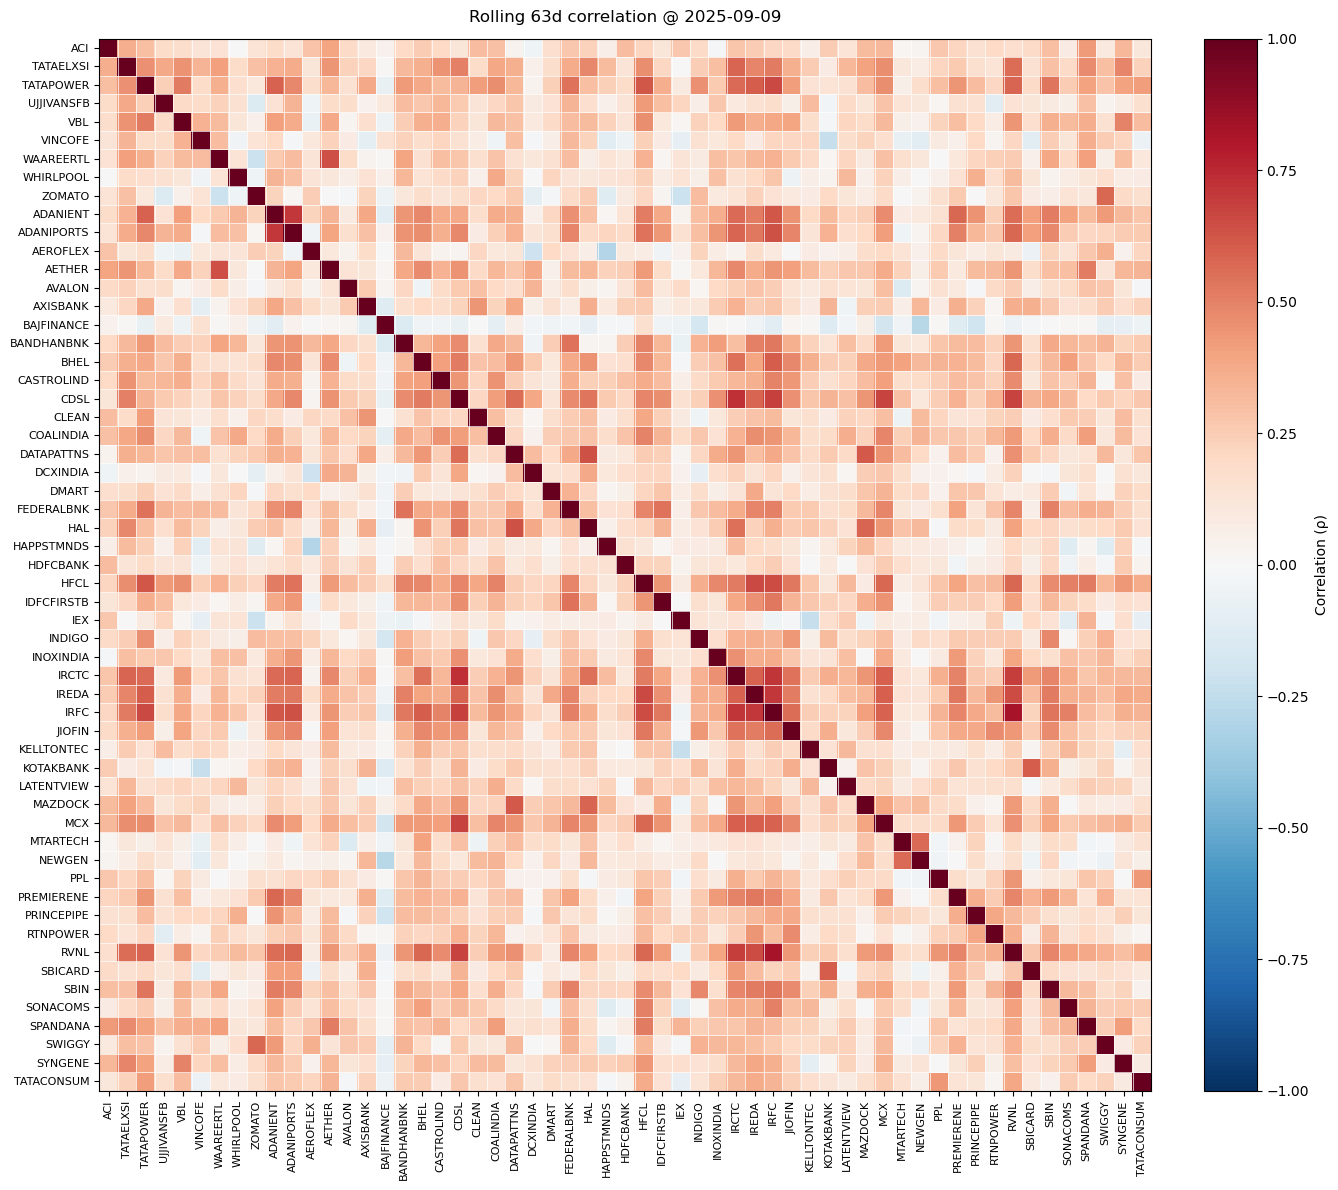

In [57]:
with open(DATA_INT / "corr_roll_63.pkl", "rb") as f:
    rc = pickle.load(f)   # dict: {date -> corr_df}
dt = sorted(rc.keys())[-1]
plot_corr_heatmap(rc[dt], title=f"Rolling 63d correlation @ {dt.date()}",
                  save_path=FIG_DIR / f"corr_heatmap_63d_{dt.date()}.png",
                  annotate_if_small=False)


In [58]:
#Portfolio return construction:

#mode="proportional" (default): each day, re-normalize weights across assets that have data that day (keeps the portfolio fully invested).

#mode="static": keep fixed weights; if a stock has NaN that day, that fraction sits in cash with 0 return.

#Stats windows: (1, 21, 63, 252) correspond to daily, ~1M, ~1Q, ~1Y trailing log‐return horizons. We compute per-stock stats and the portfolio stats from the portfolio series; you’ll use these for PDFs later.

#Z-score column: z_last uses a short 20-point rolling μ/σ for standardization of the latest observation in that horizon (keeps the signal interpretable). Change the 20 to taste.

In [59]:
# PORTFOLIO WEIGHTED

In [60]:
# ================== Portfolio Layer (weights → r_p, stats, charts) ==================
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Paths (edit if needed) --------------------------------------------------------
DATA_INT = Path(r"C:\Users\quantbase\Desktop\quant\data_int")

# ---- Load daily log returns (dates × symbols) -------------------------------------
r_1d = pd.read_pickle(DATA_INT / "log_returns_daily.pkl").sort_index()

# ---- 1) Input: weights as {name (human or ticker): % share} -----------------------
# Paste your list here (names as given by you, % as floats):
weights_input = {
    "Newgen": 7.23,
    "Ujjivan Small Fin": 6.41,
    "Rail Vikas Nigam Limited": 2.50,
    "MAN Industries": 2.70,
    "Tata Consumer Products": 3.69,
    "Data Patterns": 2.73,
    "Bajaj Finance": 4.56,
    "Railtel": 3.20,
    "Avalon Technologies": 3.64,
    "MCX": 4.26,
    "Interglobe aviation": 2.75,
    "IRFC": 0.80,
    "HDFC Bank": 1.56,
    "Avenue Supermarts": 1.52,
    "Axisbank": 0.68,
    "Central Dep Service": 2.34,
    "IRCTC": 0.57,
    "Adani Ports": 1.74,
    "Eternal (Zomato)": 0.78,
    "Inox India": 1.62,
    "Archean Chem Inds": 4.15,
    "Mazagon Dock Ship": 2.29,
    "Swiggy": 1.25,
    "Syngene": 1.37,
    "Prakash Pipes PPL": 0.35,
    "Aeroflex Industries": 0.99,
    "IDFC First Bank": 0.68,
    "Vintage Coffee": 0.55,
    "Kotak Mahindra Bank": 0.84,
    "SBI Card": 0.39,
    "Adani Enterprises": 1.74,
    "SBIN": 0.09,
    "Jio FinServ": 3.14,
    "Castrol": 0.11,
    "Happiest Minds": 0.12,
    "HAL": 0.95,
    "The Federal Bank": 0.47,
    "India Ren. Energy": 0.86,
    "Waaree Renewables": 0.54,
    "Tata Power": 0.41,
    "Kellton Tech Soln": 0.84,
    "Premier Energies": 0.64,
    "Clean Science": 0.51,
    "Coal India": 0.50,
    "Cochin Shipyard": 0.89,
    "RattanIndia Power": 0.26,
    "BHEL": 0.81,
    "Whirlpool": 0.22,
    "Varun Beverages": 0.51,
    "Jyothi Resins": 2.06,
    "Latent View Analytics": 0.83,
    "Bandhan Bank": 0.88,
    "HFCL": 0.77,
    "Aether Inds": 1.63,
    "Spandana Sphoorty": 1.22,
    "Sona BLW Precision": 1.30,
    "IEX": 0.69,
    "DCX Systems": 1.34,
    "MTAR Technologies": 3.65,
    "Tata Elxsi": 3.35,
    "Prince Pipes": 0.56,
}

# ---- 2) Alias map: human name -> dataset ticker -----------------------------------
# If a name is missing, we drop it and renormalize the rest (with a warning).
ALIAS = {
    "Newgen": "NEWGEN",
    "Ujjivan Small Fin": "UJJIVANSFB",
    "Rail Vikas Nigam Limited": "RVNL",
    "MAN Industries": "MANINDS",              # likely not in r_1d (will drop if absent)
    "Tata Consumer Products": "TATACONSUM",
    "Data Patterns": "DATAPATTNS",
    "Bajaj Finance": "BAJFINANCE",
    "Railtel": "RAILTEL",                      # likely not in r_1d (will drop)
    "Avalon Technologies": "AVALON",
    "MCX": "MCX",
    "Interglobe aviation": "INDIGO",
    "IRFC": "IRFC",
    "HDFC Bank": "HDFCBANK",
    "Avenue Supermarts": "DMART",
    "Axisbank": "AXISBANK",
    "Central Dep Service": "CDSL",
    "IRCTC": "IRCTC",
    "Adani Ports": "ADANIPORTS",
    "Eternal (Zomato)": "ZOMATO",              # or "ETERNAL" if that's your intent
    "Inox India": "INOXINDIA",
    "Archean Chem Inds": "ACI",
    "Mazagon Dock Ship": "MAZDOCK",
    "Swiggy": "SWIGGY",
    "Syngene": "SYNGENE",
    "Prakash Pipes PPL": "PPL",
    "Aeroflex Industries": "AEROFLEX",
    "IDFC First Bank": "IDFCFIRSTB",
    "Vintage Coffee": "VINCOFE",
    "Kotak Mahindra Bank": "KOTAKBANK",
    "SBI Card": "SBICARD",
    "Adani Enterprises": "ADANIENT",
    "SBIN": "SBIN",
    "Jio FinServ": "JIOFIN",
    "Castrol": "CASTROLIND",
    "Happiest Minds": "HAPPSTMNDS",
    "HAL": "HAL",
    "The Federal Bank": "FEDERALBNK",
    "India Ren. Energy": "IREDA",
    "Waaree Renewables": "WAAREERTL",
    "Tata Power": "TATAPOWER",
    "Kellton Tech Soln": "KELLTONTEC",
    "Premier Energies": "PREMIERENE",
    "Clean Science": "CLEAN",
    "Coal India": "COALINDIA",
    "Cochin Shipyard": "COCHINSHIP",           # likely missing
    "RattanIndia Power": "RTNPOWER",
    "BHEL": "BHEL",
    "Whirlpool": "WHIRLPOOL",
    "Varun Beverages": "VBL",
    "Jyothi Resins": "JYOTHIRES",              # likely missing
    "Latent View Analytics": "LATENTVIEW",
    "Bandhan Bank": "BANDHANBNK",
    "HFCL": "HFCL",
    "Aether Inds": "AETHER",
    "Spandana Sphoorty": "SPANDANA",
    "Sona BLW Precision": "SONACOMS",
    "IEX": "IEX",
    "DCX Systems": "DCXINDIA",
    "MTAR Technologies": "MTARTECH",
    "Tata Elxsi": "TATAELXSI",
    "Prince Pipes": "PRINCEPIPE",
}

# ---- 3) Utilities ------------------------------------------------------------
def build_weight_vector(weights_input: dict, columns, alias_map=ALIAS, verbose=True) -> pd.Series:
    """Map human names→tickers, drop unknowns/missing symbols, normalize to sum=1."""
    raw = {}
    for k, v in weights_input.items():
        sym = alias_map.get(k, k).upper()
        try:
            pct = float(v)
        except Exception:
            continue
        raw[sym] = raw.get(sym, 0.0) + pct

    w = pd.Series(raw, dtype=float)
    # keep only symbols present in returns
    present = w.index.intersection(pd.Index(columns).astype(str))
    missing = w.index.difference(present)
    if verbose and len(missing):
        print("Dropped (not found in returns):", ", ".join(missing))

    w = w.loc[present]
    if w.sum() <= 0:
        raise ValueError("No valid weights after mapping to tickers.")
    w = w / w.sum()  # normalize to 1
    return w.sort_values(ascending=False)

def plot_weights_pie(w: pd.Series, max_labels: int = 20, title="Portfolio weights"):
    """Simple pie: top N labels, rest grouped as 'Other'."""
    w = w.sort_values(ascending=False)
    if len(w) > max_labels:
        top = w.iloc[:max_labels]
        other = pd.Series({"Other": w.iloc[max_labels:].sum()})
        w = pd.concat([top, other])
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.pie(w.values, labels=w.index, autopct="%1.1f%%", startangle=90)
    ax.set_title(title)
    ax.axis("equal")
    plt.show()

def portfolio_returns(r_1d: pd.DataFrame, w: pd.Series, mode: str = "proportional") -> pd.Series:
    """
    Build portfolio daily log returns from asset log returns.
    mode='proportional': re-normalize weights each day across available (non-NaN) assets.
    mode='static': use fixed weights; missing asset returns treated as 0 (weight sits in cash).
    """
    w = w.reindex(r_1d.columns).fillna(0.0)
    if mode == "static":
        return (r_1d.fillna(0.0) * w).sum(axis=1)

    # proportional reweighting among assets that have data each day
    mask = r_1d.notna().astype(float)
    denom = (mask * w).sum(axis=1).replace(0, np.nan)  # sum of available weights
    adj_w = mask.mul(w, axis=1).div(denom, axis=0).fillna(0.0)
    r_p = (r_1d.fillna(0.0) * adj_w).sum(axis=1)
    return r_p

def trailing_log_returns(x: pd.Series, window: int, min_frac: float = 0.80) -> pd.Series:
    """Rolling sum of daily log returns over 'window' with min data fraction."""
    minp = max(1, int(np.ceil(window * min_frac)))
    return x.rolling(window, min_periods=minp).sum()

def stats_series(x: pd.Series):
    """μ, σ, skew, kurt over non-NaN; z_last uses rolling μ/σ over same window if applicable."""
    s = x.dropna()
    if s.empty:
        return dict(n=0, mu=np.nan, sigma=np.nan, skew=np.nan, kurt=np.nan)
    return dict(n=int(s.size), mu=float(s.mean()), sigma=float(s.std(ddof=1)),
                skew=float(s.skew()), kurt=float(s.kurt()))

def build_stats_tables(r_1d: pd.DataFrame, w: pd.Series, r_p: pd.Series,
                       windows=(1, 21, 63, 252), min_frac=0.80):
    """
    For each window, compute per-stock stats and portfolio stats on trailing log returns:
    - window=1 is just daily returns
    - returns: dict {window: (per_stock_df, portfolio_row)}
    """
    out = {}
    for win in windows:
        if win == 1:
            R_assets = r_1d
            R_port = r_p
        else:
            R_assets = r_1d.apply(trailing_log_returns, window=win, min_frac=min_frac)
            R_port = trailing_log_returns(r_p, window=win, min_frac=min_frac)

        rows = []
        for sym in w.index:
            st = stats_series(R_assets[sym])
            # z_last within this horizon (use last window μ/σ from the time-series itself)
            z_last = np.nan
            s = R_assets[sym].dropna()
            if s.size >= 20:
                mu = s.rolling(20, min_periods=10).mean().iloc[-1]
                sd = s.rolling(20, min_periods=10).std(ddof=1).iloc[-1]
                if sd and not np.isnan(sd):
                    z_last = float((s.iloc[-1] - mu) / sd)
            rows.append({
                "symbol": sym, "weight": float(w[sym]),
                "n": st["n"], "mu": st["mu"], "sigma": st["sigma"],
                "skew": st["skew"], "kurt": st["kurt"], "z_last": z_last
            })
        per_stock = pd.DataFrame(rows).sort_values("weight", ascending=False).reset_index(drop=True)

        # Portfolio stats for the same horizon (computed directly on portfolio series)
        st_p = stats_series(R_port)
        # portfolio z_last with same logic
        z_last_p = np.nan
        sp = R_port.dropna()
        if sp.size >= 20:
            mu = sp.rolling(20, min_periods=10).mean().iloc[-1]
            sd = sp.rolling(20, min_periods=10).std(ddof=1).iloc[-1]
            if sd and not np.isnan(sd):
                z_last_p = float((sp.iloc[-1] - mu) / sd)
        port_row = pd.DataFrame([{
            "symbol": "PORTFOLIO", "weight": 1.0,
            "n": st_p["n"], "mu": st_p["mu"], "sigma": st_p["sigma"],
            "skew": st_p["skew"], "kurt": st_p["kurt"], "z_last": z_last_p
        }])

        out[win] = (per_stock, port_row)
    return out

def plot_portfolio_value(r_p: pd.Series, V0: float = 100_000.0, title="Portfolio value (log-return compounding)"):
    """Line chart of portfolio value = V0 * exp(cumsum(log returns))."""
    val = V0 * np.exp(r_p.cumsum())
    fig, ax = plt.subplots(figsize=(11, 5))
    ax.plot(val.index, val.values, linewidth=2)
    ax.set_title(title)
    ax.set_ylabel("Value (INR)")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    return val


Dropped (not found in returns): COCHINSHIP, JYOTHIRES, MANINDS, RAILTEL


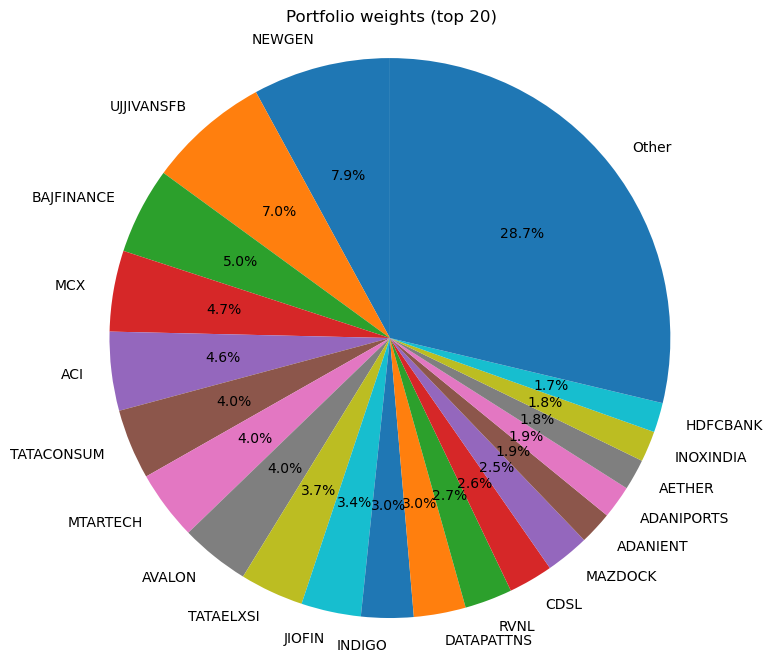

In [61]:
# ---- 4) Build clean weights, pie chart --------------------------------------
weights = build_weight_vector(weights_input, r_1d.columns, alias_map=ALIAS, verbose=True)
plot_weights_pie(weights, max_labels=20, title="Portfolio weights (top 20)")

# ---- 5) Portfolio daily returns ---------------------------------------------
# Choose mode: "proportional" (default) or "static"
r_p = portfolio_returns(r_1d, weights, mode="proportional")

# ---- 6) Stats tables for multiple horizons ----------------------------------
stats_out = build_stats_tables(r_1d, weights, r_p, windows=(1, 5, 21, 63, 252), min_frac=0.80)



In [62]:
# Example: show daily (1) and 21-day tables
per_stock_1d, port_1d = stats_out[1]
per_stock_5, port_w = stats_out[5]
per_stock_21, port_m = stats_out[21]
per_stock_63, port_q = stats_out[63]
per_stock_252, port_y = stats_out[252]


display(per_stock_1d.head(10))
display(port_1d)

display(per_stock_5.head(10))
display(port_m)

display(per_stock_21.head(10))
display(port_m)

display(per_stock_63.head(10))
display(port_q)

display(per_stock_252.head(10))
display(port_y)

,symbol,weight,n,mu,sigma,skew,kurt,z_last
0,NEWGEN,0.079294,785,0.001290,0.030424,0.135454,4.305673,-0.393566
1,UJJIVANSFB,0.070301,855,0.001344,0.024609,0.676534,2.409739,2.913487
2,BAJFINANCE,0.050011,855,-0.002379,0.080359,-27.333308,781.431677,0.023539
3,MCX,0.046721,855,0.001952,0.024024,-0.159449,2.262940,-0.082194
4,ACI,0.045514,696,0.000584,0.023805,0.466187,1.587106,-0.345976
5,TATACONSUM,0.040469,855,0.000406,0.014145,0.050733,2.587691,0.538671
6,MTARTECH,0.040031,855,-0.000261,0.022715,0.205987,4.847256,-0.002430
7,AVALON,0.039921,596,0.001439,0.029570,0.758660,4.200452,0.314826
8,TATAELXSI,0.036741,855,-0.000564,0.019318,0.863043,10.153758,1.341267
9,JIOFIN,0.034437,500,0.000390,0.021706,0.445542,4.303874,-0.792378


,symbol,weight,n,mu,sigma,skew,kurt,z_last
0,PORTFOLIO,1.0,856,0.000603,0.012794,-1.547599,8.514479,0.332565


,symbol,weight,n,mu,sigma,skew,kurt,z_last
0,NEWGEN,0.079294,780,0.006742,0.069217,-0.460120,3.958554,-0.382270
1,UJJIVANSFB,0.070301,852,0.006021,0.057822,0.451893,1.311082,3.069459
2,BAJFINANCE,0.050011,852,-0.012104,0.182365,-12.115920,152.007905,1.408176
3,MCX,0.046721,852,0.009810,0.053945,0.005348,0.547838,0.040006
4,ACI,0.045514,693,0.002791,0.058836,-0.134154,1.571095,-0.170555
5,TATACONSUM,0.040469,852,0.001936,0.030041,0.048939,1.209047,-0.964037
6,MTARTECH,0.040031,852,-0.001271,0.054160,0.037340,1.647726,-0.079852
7,AVALON,0.039921,593,0.006864,0.066773,0.160845,2.615796,1.971591
8,TATAELXSI,0.036741,852,-0.002895,0.045530,0.482401,3.377443,1.221903
9,JIOFIN,0.034437,497,0.002042,0.046401,0.070560,1.505064,0.075864


,symbol,weight,n,mu,sigma,skew,kurt,z_last
0,PORTFOLIO,1.0,840,0.011957,0.064231,-0.443394,-0.388214,1.453446


,symbol,weight,n,mu,sigma,skew,kurt,z_last
0,NEWGEN,0.079294,757,0.025164,0.152934,-0.524372,1.382319,0.162247
1,UJJIVANSFB,0.070301,839,0.023645,0.106640,0.333618,-0.560528,2.272700
2,BAJFINANCE,0.050011,839,-0.052429,0.369151,-5.628177,31.577280,1.798966
3,MCX,0.046721,839,0.042859,0.111482,0.145155,-0.371021,-0.736597
4,ACI,0.045514,680,0.009085,0.108010,-0.020699,0.069817,1.731014
5,TATACONSUM,0.040469,839,0.007505,0.064738,0.105851,0.905847,1.323907
6,MTARTECH,0.040031,839,-0.004425,0.097732,0.248066,0.246325,-0.627543
7,AVALON,0.039921,580,0.029714,0.142823,0.055101,1.563595,-0.797720
8,TATAELXSI,0.036741,839,-0.010867,0.091809,0.253350,0.212202,1.817762
9,JIOFIN,0.034437,484,0.011860,0.101331,-0.062092,0.252386,-1.221215


,symbol,weight,n,mu,sigma,skew,kurt,z_last
0,PORTFOLIO,1.0,840,0.011957,0.064231,-0.443394,-0.388214,1.453446


,symbol,weight,n,mu,sigma,skew,kurt,z_last
0,NEWGEN,0.079294,697,0.093595,0.242883,-0.818040,-0.005664,-0.229314
1,UJJIVANSFB,0.070301,805,0.079921,0.211789,0.326205,-1.002808,-1.286343
2,BAJFINANCE,0.050011,805,-0.145781,0.621983,-3.007382,7.641411,0.886415
3,MCX,0.046721,805,0.140057,0.205568,0.414249,-0.249279,-1.987961
4,ACI,0.045514,646,0.021886,0.156752,-0.172627,0.088898,-0.324666
5,TATACONSUM,0.040469,805,0.026535,0.115696,-0.346922,0.138451,0.800770
6,MTARTECH,0.040031,805,-0.002974,0.164767,-0.065205,-0.634726,-1.552478
7,AVALON,0.039921,546,0.080733,0.207080,0.707512,0.153458,2.361727
8,TATAELXSI,0.036741,805,-0.026076,0.144589,-0.189129,-0.192740,-1.015217
9,JIOFIN,0.034437,450,0.043553,0.218523,-0.088241,-0.529718,-1.659446


,symbol,weight,n,mu,sigma,skew,kurt,z_last
0,PORTFOLIO,1.0,806,0.045787,0.116107,-0.449885,-0.451306,-1.441665


,symbol,weight,n,mu,sigma,skew,kurt,z_last
0,NEWGEN,0.079294,433,0.438008,0.439703,0.268567,-1.132413,-0.088366
1,UJJIVANSFB,0.070301,654,0.266112,0.493176,-0.234091,-1.393548,2.401893
2,BAJFINANCE,0.050011,654,-0.137881,0.619518,-2.557894,5.143431,-0.389368
3,MCX,0.046721,654,0.589827,0.346935,-0.189958,-1.061849,-1.464047
4,ACI,0.045514,495,0.070915,0.173837,-0.524582,0.292613,0.582507
5,TATACONSUM,0.040469,654,0.115584,0.199864,0.354922,-0.967401,0.196253
6,MTARTECH,0.040031,654,-0.003504,0.286475,0.326978,-1.012367,-1.065817
7,AVALON,0.039921,395,0.294501,0.231823,-0.476134,-0.600509,0.869593
8,TATAELXSI,0.036741,654,-0.093936,0.195632,0.322479,-0.568520,-0.521571
9,JIOFIN,0.034437,299,0.044913,0.287516,-0.270356,-1.290562,-2.036243


,symbol,weight,n,mu,sigma,skew,kurt,z_last
0,PORTFOLIO,1.0,655,0.235861,0.225111,-0.465154,-0.981642,-0.272206


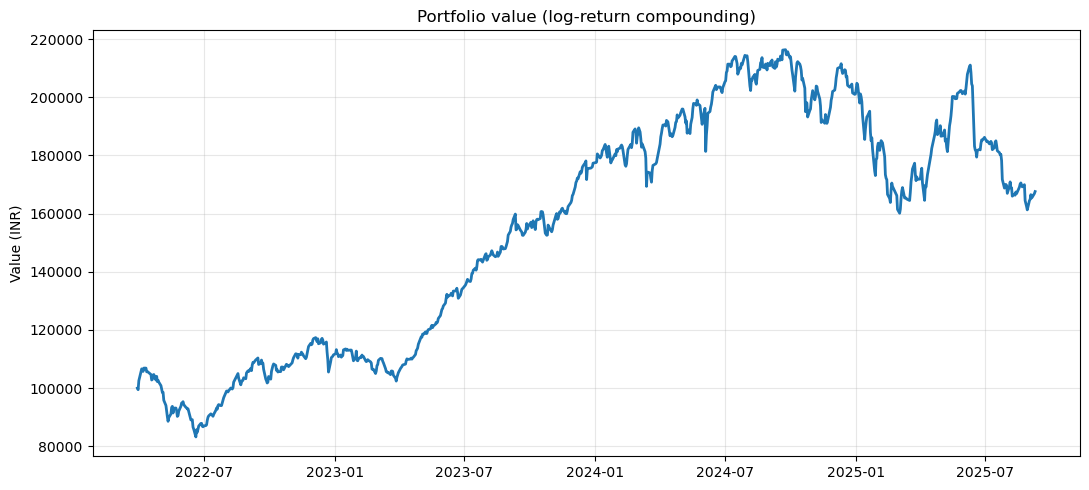

In [63]:
# ---- 7) Portfolio value curve (default ₹100,000) ----------------------------
portfolio_value = plot_portfolio_value(r_p, V0=100_000)

In [64]:
# ---- 8) (Optional) Save artifacts ------------------------------------------
r_p.to_pickle(DATA_INT / "portfolio_returns.pkl")
portfolio_value.to_csv(DATA_INT / "portfolio_value_100k.csv", header=["value"])
# Persist stats
for win, (per_stock_df, port_row) in stats_out.items():
    per_stock_df.to_csv(DATA_INT / f"portfolio_stats_stocks_w{win}.csv", index=False)
    port_row.to_csv(DATA_INT / f"portfolio_stats_port_w{win}.csv", index=False)
print("Saved: portfolio_returns.pkl, portfolio_value_100k.csv, portfolio_stats_*.csv")
# ============================================================================ #


Saved: portfolio_returns.pkl, portfolio_value_100k.csv, portfolio_stats_*.csv


In [65]:
# Distributions

C:\Users\quantbase\AppData\Local\Temp\ipykernel_27628\2854342426.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{v*100:.1f}%" for v in locs])


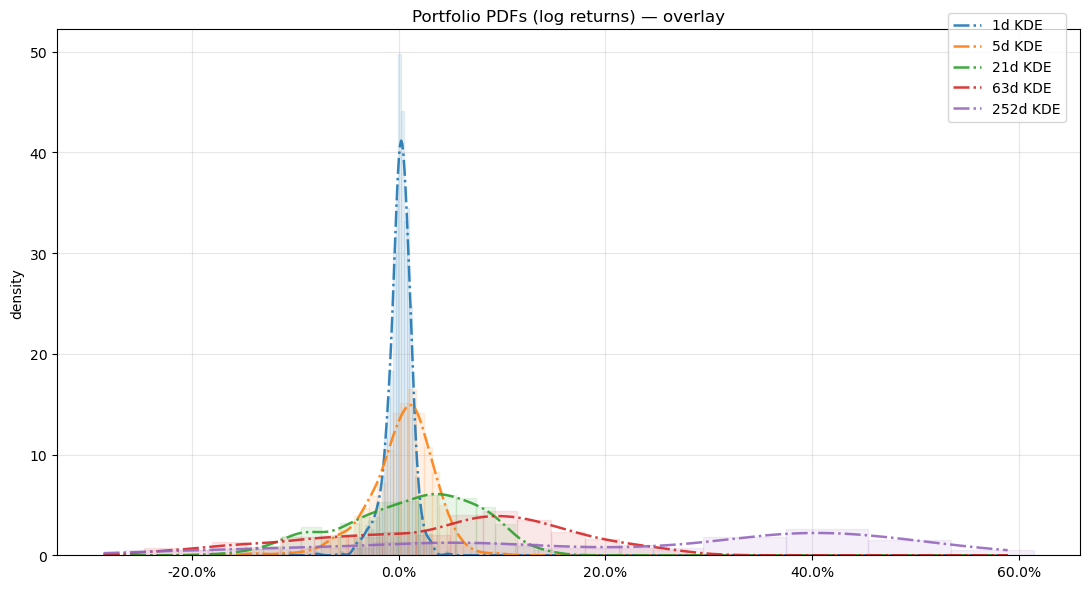

In [66]:
# =================== Portfolio PDFs (Normal / KDE / t) =======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st

# reuse your trailing helper
def trailing_log_returns(x: pd.Series, window: int, min_frac: float = 0.80) -> pd.Series:
    minp = max(1, int(np.ceil(window * min_frac)))
    return x.rolling(window, min_periods=minp).sum()

def _fit_normal(x: np.ndarray):
    mu = float(np.mean(x))
    sd = float(np.std(x, ddof=1)) if x.size > 1 else np.nan
    return mu, sd

def _fit_t(x: np.ndarray):
    # robust wrapper around Student-t MLE; fallback to normal if it fails
    try:
        df, loc, scale = st.t.fit(x)
        return float(df), float(loc), float(scale)
    except Exception:
        mu, sd = _fit_normal(x)
        # df large ~ normal; encode as None to signal "skip" if desired
        return None, mu, sd

def _kde_eval(x: np.ndarray, grid: np.ndarray, bw=None):
    try:
        kde = st.gaussian_kde(x) if bw is None else st.gaussian_kde(x, bw_method=bw)
        return kde(grid)
    except Exception:
        return None

def _nice_grid(series_list, p_lo=0.01, p_hi=0.99, pad=0.10, n=800):
    # common X grid across timeframes using pooled percentiles
    vals = np.concatenate([s[~np.isnan(s.values)] for s in series_list if len(s.dropna()) > 1]) \
           if len(series_list) else np.array([])
    if vals.size >= 5:
        lo, hi = np.quantile(vals, [p_lo, p_hi])
        rng = max(1e-9, hi - lo)
        lo -= pad*rng; hi += pad*rng
    else:
        lo, hi = -0.1, 0.1  # safe fallback (~±10% log return)
    return np.linspace(lo, hi, n)

def _percent_axis(ax):
    # show x as percent
    locs = ax.get_xticks()
    ax.set_xticklabels([f"{v*100:.1f}%" for v in locs])

def plot_portfolio_pdfs(
    r_p: pd.Series,
    windows=(1, 5, 21, 63, 252),
    show_normal=True,
    show_kde=True,
    show_t=True,
    overlay=True,
    draw_sigma=True,
    kde_bw=None,
    title="Portfolio PDFs (log returns)"
):
    """
    r_p: daily portfolio log returns
    windows: iterable of windows (1=1D, 5≈1W, 21≈1M, 63≈1Q, 252≈1Y)
    overlay: True → one axes with all windows; False → separate subplots
    draw_sigma: draw ±1σ and ±2σ (from Normal fit) for each window
    kde_bw: pass a float or callable for scipy KDE bandwidth; None → default (Scott)
    """
    # build trailing series for each window
    series_by_w = {}
    for w in windows:
        s = r_p if w == 1 else trailing_log_returns(r_p, window=w, min_frac=0.80)
        s = s.dropna()
        if s.size >= 5:
            series_by_w[w] = s

    if not series_by_w:
        raise ValueError("No window had enough data to plot.")

    # common grid across chosen windows
    grid = _nice_grid(list(series_by_w.values()))

    # color cycle for consistency across windows
    prop_cycle = plt.rcParams["axes.prop_cycle"].by_key().get("color", ["C0","C1","C2","C3","C4","C5"])
    win_list = list(series_by_w.keys())

    if overlay:
        fig, ax = plt.subplots(figsize=(11, 6))
        axes = [ax]
    else:
        n = len(win_list)
        fig, axes = plt.subplots(n, 1, figsize=(11, max(3, 2.8*n)), sharex=True)
        if n == 1: axes = [axes]

    legend_entries = []

    for i, w in enumerate(win_list):
        s = series_by_w[w]
        x = s.values
        color = prop_cycle[i % len(prop_cycle)]
        ax = axes[0] if overlay else axes[i]

        # histogram outline for context (density=True so area≈1)
        counts, bins, _ = ax.hist(x, bins="auto", density=True, alpha=0.10,
                                  edgecolor=color, facecolor=color, label=None)

        # Normal fit
        mu, sd = _fit_normal(x)
        if show_normal and np.isfinite(sd) and sd > 0:
            yN = st.norm.pdf(grid, loc=mu, scale=sd)
            ax.plot(grid, yN, linestyle="-", linewidth=2, color=color,
                    label=f"{w}d Normal(μ={mu:.3f}, σ={sd:.3f})")
            # sigma lines
            if draw_sigma:
                for k, ls in zip((1,2), ("--", ":")):
                    ax.axvline(mu + k*sd, color=color, linestyle=ls, alpha=0.8)
                    ax.axvline(mu - k*sd, color=color, linestyle=ls, alpha=0.8)

        # KDE
        if show_kde:
            yK = _kde_eval(x, grid, bw=kde_bw)
            if yK is not None:
                ax.plot(grid, yK, linestyle="-.", linewidth=1.8, color=color,
                        alpha=0.9, label=f"{w}d KDE")

        # Student-t
        if show_t:
            df, loc, scale = _fit_t(x)
            if df is not None and np.isfinite(scale) and scale > 0:
                yT = st.t.pdf(grid, df=df, loc=loc, scale=scale)
                ax.plot(grid, yT, linestyle="--", linewidth=1.8, color=color,
                        alpha=0.9, label=f"{w}d t(df≈{df:.1f})")

        if not overlay:
            ax.set_title(f"{title} — {w}d")
            ax.grid(True, alpha=0.3)

    # cosmetics
    main_ax = axes[0]
    _percent_axis(main_ax)
    if overlay:
        main_ax.set_title(title + " — overlay")
    main_ax.set_ylabel("density")
    main_ax.grid(True, alpha=0.3)
    fig.legend(loc="upper right", bbox_to_anchor=(0.98, 0.98), frameon=True)
    plt.tight_layout()
    plt.show()

# ---- Example use --------------------------------------------------------------
# Add 5d into the earlier stats call (you already did this in your code):
# stats_out = build_stats_tables(r_1d, weights, r_p, windows=(1, 5, 21, 63, 252), min_frac=0.80)

# Plot PDFs, all timeframes in one plot:
plot_portfolio_pdfs(
    r_p,
    windows=(1, 5, 21, 63, 252),
    show_normal=False, show_kde=True, show_t=False,
    overlay=True,          # set False to get stacked subplots
    draw_sigma=False,       # vertical ±1σ/±2σ per window (Normal fit)
    kde_bw=None,           # or e.g. kde_bw=0.5 to widen, 0.2 to narrow
    title="Portfolio PDFs (log returns)"
)


In [67]:
#Notes & choices

#λ selection: 0.94 is the classic RiskMetrics daily value; 0.97 (or 0.985) is smoother. You can add more lambdas to LAMBDAS.

#Seeding: we “backcast” using the mean of the first 60 valid squared returns (fallbacks included).
#This avoids an unrealistically low/high starting σ.

#NaNs: when a day’s return is NaN, we propagate the previous variance (no update), which is a standard pragmatic choice.

#Portfolio EWMA: computed directly from your actual r_p series via the same recursion, 
#so it’s consistent with whatever weighting logic you used earlier (proportional/static).

#Sanity visuals: plot_asset_vol() and plot_portfolio_vol() overlay EWMA (annualized) with realized rolling σ to check behaviour.

In [68]:
# RVol and EWMA

In [69]:
# ===================== EWMA Volatility (stocks + portfolio) =====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---- Paths -------------------------------------------------------------------
DATA_INT = Path(r"C:\Users\quantbase\Desktop\quant\data_int")
FIG_DIR  = Path(r"C:\Users\quantbase\Desktop\quant\figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

# ---- Load daily log returns & (optionally) portfolio series -------------------
r_1d = pd.read_pickle(DATA_INT / "log_returns_daily.pkl").sort_index()

# We expect r_p from your previous portfolio step; if missing, try to load it.
try:
    r_p
except NameError:
    rp_path = DATA_INT / "portfolio_returns.pkl"
    if rp_path.exists():
        r_p = pd.read_pickle(rp_path).sort_index()
    else:
        raise RuntimeError("Portfolio series r_p not found. Please run the portfolio block first or save it to data_int/portfolio_returns.pkl")

# ---- Helpers -----------------------------------------------------------------
def ewma_var_series(x: pd.Series, lam: float = 0.94, backcast_n: int = 60) -> pd.Series:
    """
    EWMA variance σ_t^2 = λ σ_{t-1}^2 + (1-λ) r_t^2
    - Preserves index & NaNs.
    - If r_t is NaN, we propagate σ_t^2 = σ_{t-1}^2 (no update).
    - Seed/backcast: use mean(r^2) over first backcast_n valid points (fallback to global mean if shorter).
    """
    x = x.astype(float)
    r2 = x * x
    out = pd.Series(index=x.index, dtype=float)

    # find first valid observation to seed
    first_valid = r2.first_valid_index()
    if first_valid is None:
        return out  # all NaN

    # backcast seed
    s = r2.loc[first_valid:].dropna().iloc[:max(1, backcast_n)]
    seed = float(s.mean()) if not s.empty else float(r2.dropna().mean()) if r2.dropna().size else 0.0
    prev = seed

    for t in x.index:
        rt2 = r2.loc[t]
        if np.isnan(rt2):
            # no new info; keep decaying previous variance
            curr = prev
        else:
            curr = lam * prev + (1.0 - lam) * rt2
        out.loc[t] = curr
        prev = curr
    return out

def ewma_vol_df(df: pd.DataFrame, lam: float = 0.94, backcast_n: int = 60) -> pd.DataFrame:
    """Column-wise EWMA daily volatility (σ = sqrt(variance))."""
    cols = {}
    for c in df.columns:
        v = ewma_var_series(df[c], lam=lam, backcast_n=backcast_n)
        cols[c] = np.sqrt(v)
    return pd.DataFrame(cols, index=df.index)

def rolling_realized_vol(x: pd.Series, window: int, min_frac: float = 0.80) -> pd.Series:
    """Rolling stdev of daily returns, gap-aware via min_periods."""
    minp = max(1, int(np.ceil(window * min_frac)))
    return x.rolling(window, min_periods=minp).std(ddof=1)

def annualize_sigma(sigma_daily: pd.Series) -> pd.Series:
    """σ_annual = σ_daily * sqrt(252)."""
    return sigma_daily * np.sqrt(252.0)

# ---- Parameters ---------------------------------------------------------------
LAMBDAS = [0.94, 0.97]
ROLL_WINS = (21, 63, 252)  # realized vol comparisons

# ---- 1) Per-stock EWMA vol (daily & annualized) ------------------------------
ewma_vol_daily = {}
ewma_vol_annual = {}
for lam in LAMBDAS:
    sig = ewma_vol_df(r_1d, lam=lam, backcast_n=60)
    ewma_vol_daily[lam]  = sig
    ewma_vol_annual[lam] = sig.apply(annualize_sigma)

    # save artifacts
    sig.to_pickle(DATA_INT / f"ewma_vol_daily_lambda{int(lam*100):02d}.pkl")
    ewma_vol_annual[lam].to_pickle(DATA_INT / f"ewma_vol_annual_lambda{int(lam*100):02d}.pkl")

print("Saved per-stock EWMA vol pickles:", [f"lambda{int(l*100):02d}" for l in LAMBDAS])

# ---- 2) Portfolio EWMA vol from r_p (daily & annualized) ---------------------
port_ewma_daily = {}
port_ewma_annual = {}
for lam in LAMBDAS:
    var_p = ewma_var_series(r_p, lam=lam, backcast_n=60)
    sig_p = np.sqrt(var_p)
    port_ewma_daily[lam]  = sig_p
    port_ewma_annual[lam] = annualize_sigma(sig_p)

    sig_p.to_pickle(DATA_INT / f"portfolio_ewma_vol_daily_lambda{int(lam*100):02d}.pkl")
    port_ewma_annual[lam].to_pickle(DATA_INT / f"portfolio_ewma_vol_annual_lambda{int(lam*100):02d}.pkl")

print("Saved portfolio EWMA vol pickles:", [f"lambda{int(l*100):02d}" for l in LAMBDAS])

# ---- 3) Quick sanity plot: per-stock (choose sym) vs realized vol ------------
def plot_asset_vol(symbol: str,
                   lam: float = 0.94,
                   realized_windows = (21, 63, 252),
                   title_prefix="Volatility"):
    if symbol not in r_1d.columns:
        raise KeyError(f"{symbol} not found in returns columns.")
    sig_ewma = ewma_vol_daily[lam][symbol]
    plt.figure(figsize=(11,4))
    plt.plot(sig_ewma.index, annualize_sigma(sig_ewma), label=f"EWMA (λ={lam}) ann", linewidth=2)
    for w in realized_windows:
        rv = annualize_sigma(rolling_realized_vol(r_1d[symbol], window=w))
        plt.plot(rv.index, rv, label=f"Realized {w}d ann", alpha=0.9)
    plt.title(f"{title_prefix}: {symbol}")
    plt.ylabel("σ (annualized)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()



Saved per-stock EWMA vol pickles: ['lambda94', 'lambda97']
Saved portfolio EWMA vol pickles: ['lambda94', 'lambda97']


In [70]:
# Example: uncomment to view
#plot_asset_vol("SBIN", lam=0.94)


In [71]:
# ---- 4) Portfolio vol plot: EWMA vs realized rolling vol ---------------------
def plot_portfolio_vol(lam: float = 0.94,
                       realized_windows = (21, 63, 252),
                       title="Portfolio volatility (annualized)"):
    sigp = port_ewma_daily[lam]
    plt.figure(figsize=(11,4))
    plt.plot(sigp.index, annualize_sigma(sigp), label=f"Portfolio EWMA (λ={lam}) ann", linewidth=2)
    for w in realized_windows:
        rv = annualize_sigma(rolling_realized_vol(r_p, window=w))
        plt.plot(rv.index, rv, label=f"Realized {w}d ann", alpha=0.9)
    plt.title(title)
    plt.ylabel("σ (annualized)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()



In [72]:
# Example: uncomment to view
#plot_portfolio_vol(lam=0.94)



In [73]:
# ---- 5) Tiny summary print ---------------------------------------------------
last_date = r_1d.index.max()
summ = {f"EWMA_ann_{int(l*100):02d}": float(port_ewma_annual[l].dropna().iloc[-1]) for l in LAMBDAS}
realized_snaps = {f"Realized_ann_{w}": float(annualize_sigma(rolling_realized_vol(r_p, w)).dropna().iloc[-1]) for w in ROLL_WINS if not rolling_realized_vol(r_p, w).dropna().empty}
print(f"Last date: {last_date.date()} | Portfolio σ (annualized):", {**summ, **realized_snaps})


Last date: 2025-09-09 | Portfolio σ (annualized): {'EWMA_ann_94': 0.18669676302781973, 'EWMA_ann_97': 0.2174375217833758, 'Realized_ann_21': 0.17779967993857423, 'Realized_ann_63': 0.2661854909708211, 'Realized_ann_252': 0.24481880194497108}


In [74]:
# FORECAST

In [75]:
# ================= Forward finite-window EWMA forecast paths (stand-alone) =================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pandas.tseries.offsets import BDay
from pathlib import Path

# --- paths & data --------------------------------------------------------------
DATA_INT = Path(r"C:\Users\quantbase\Desktop\quant\data_int")
r_1d = pd.read_pickle(DATA_INT / "log_returns_daily.pkl").sort_index()

# If you saved portfolio returns earlier as data_int/portfolio_returns.pkl, we can load it:
try:
    r_p
except NameError:
    rp_path = DATA_INT / "portfolio_returns.pkl"
    r_p = pd.read_pickle(rp_path).sort_index() if rp_path.exists() else None

# --- helpers -------------------------------------------------------------------
def get_series(target: str) -> pd.Series:
    """target: stock symbol in r_1d.columns, or 'PORTFOLIO' if r_p available."""
    t = target.upper()
    if t == "PORTFOLIO":
        if r_p is None:
            raise RuntimeError("Portfolio series r_p not found. Run/save the portfolio block first.")
        return r_p
    if t not in r_1d.columns:
        raise KeyError(f"{t} not found in returns columns.")
    return r_1d[t]

def ewma_weights(lam: float, n: int) -> np.ndarray:
    """
    α(i) = [(1-λ) * λ^(i-1)] / [1 - λ^n],  i=1..n
    Returned as vector w (oldest→newest), length n, sum(w)=1.
    """
    w = (1 - lam) * lam**np.arange(n)    # oldest→newest
    denom = 1.0 - lam**n
    if denom == 0:
        # degenerate case (λ≈1 with n→∞). Use plain geometric normalisation fallback.
        w = lam**np.arange(n)
        w = w / w.sum()
    else:
        w = w / denom
    return w

def forward_finite_ewma_paths(x: pd.Series,
                              windows=(2, 5, 21, 63, 252),
                              lam: float = 0.94,
                              future_days: int = 30,
                              annualize: bool = True) -> dict:
    """
    Build forward 'forecast' series for each window k in `windows`:
      For j=0..M-1, compute σ_hat_t-j(k)^2 = sum_{i=1..k} α(i) * r_{t-j-(k-i)}^2  (finite-window EWMA),
      then convert to k-day period vol: σ_k = sqrt(k * σ_daily^2).
      Map each value to future dates: (t+BDay(1), t+BDay(2), ...).

    Returns: dict {k: pd.Series(future_dates → σ_k)}, where σ is annualised if `annualize=True`.
    """
    s = x.dropna()
    if s.size == 0:
        return {}
    last_date = s.index.max()

    out = {}
    for k in windows:
        if k < 2:
            # Per your spec, skip 1-day horizon
            continue
        if s.size < k:
            # not enough history to compute even the first point
            continue

        w = ewma_weights(lam, k)                      # oldest→newest, sum=1
        r2 = (s.values)**2                            # ndarray for speed

        # number of valid backward windows we can take
        max_windows = s.size - k + 1
        m = min(future_days, max_windows)             # cap by history availability

        vals = np.empty(m, dtype=float)
        # For j=0..m-1: window ends at index -1-j, starts at -k-j (inclusive)
        for j in range(m):
            end = s.size - j          # exclusive slice end
            start = end - k           # inclusive start
            window_r2 = r2[start:end] # length k, oldest→newest
            # finite-window EWMA daily var estimate at "today minus j"
            var_daily = float(np.dot(w, window_r2))
            # scale to k-day period volatility
            sigma_k = np.sqrt(k * var_daily)
            vals[j] = sigma_k

        # map to FUTURE business dates t+1..t+m
        future_idx = pd.bdate_range(start=last_date + BDay(1), periods=m)
        ser = pd.Series(vals[::-1], index=future_idx)  # reverse so it goes left→right in time

        if annualize:
            ser = ser * np.sqrt(252.0)
        out[int(k)] = ser

    return out

def plot_forward_finite_ewma(target: str,
                             windows=(5, 21, 63, 252),
                             lam: float = 0.94,
                             future_days: int = 30,
                             annualize: bool = True,
                             title="Forward finite-window EWMA (period σ)"):
    """
    Stand-alone plot: forward paths only, no realised overlays, no markers.
    Each line is a k-day *period* volatility (annualised if chosen) mapped onto future dates.
    """
    x = get_series(target)
    paths = forward_finite_ewma_paths(x, windows=windows, lam=lam,
                                      future_days=future_days, annualize=annualize)
    if not paths:
        raise RuntimeError("No forward paths could be computed (insufficient history?).")

    fig, ax = plt.subplots(figsize=(11, 5))
    for k, ser in sorted(paths.items()):
        ax.plot(ser.index, ser.values, lw=2, label=f"{k}d EWMA (λ={lam})")

    ax.set_title(f"{title} — {target.upper()}")
    ax.set_ylabel("σ (annualised)" if annualize else "σ (period)")
    ax.grid(True, alpha=0.3)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{100*v:.1f}%"))
    ax.legend(ncol=2)
    plt.tight_layout()
    plt.show()


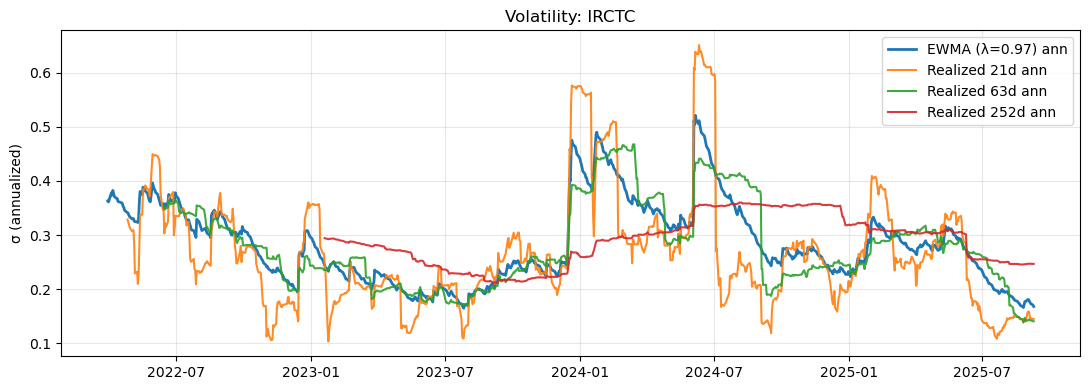

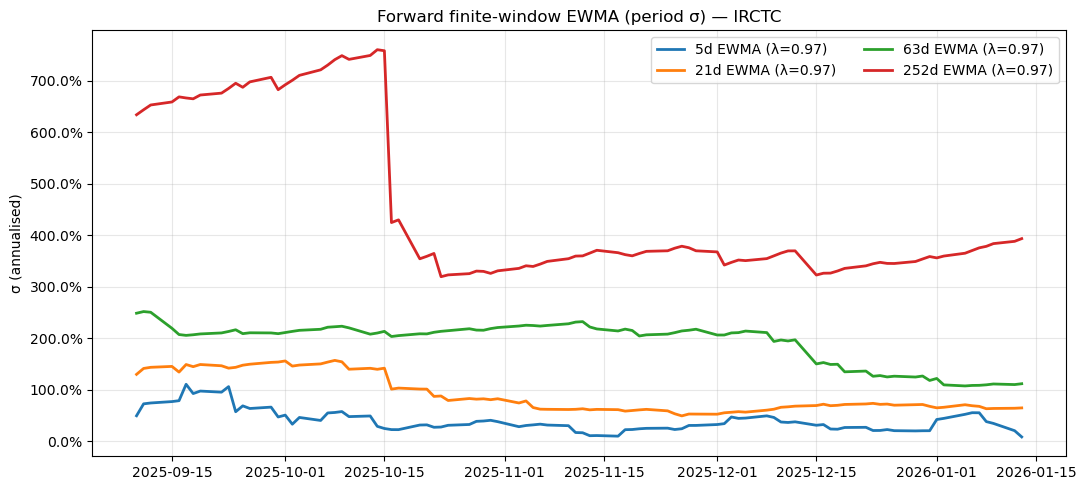

In [76]:
# Single stock, λ=0.97, just 5d and 21d forward paths for 40 business days
plot_asset_vol("IRCTC", lam=0.97)
plot_forward_finite_ewma("IRCTC", windows=(5,21,63,252), lam=0.97, future_days=90)


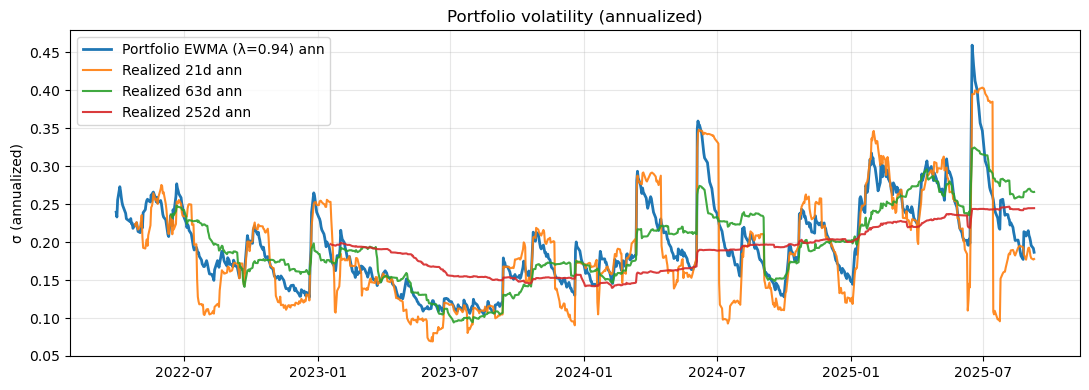

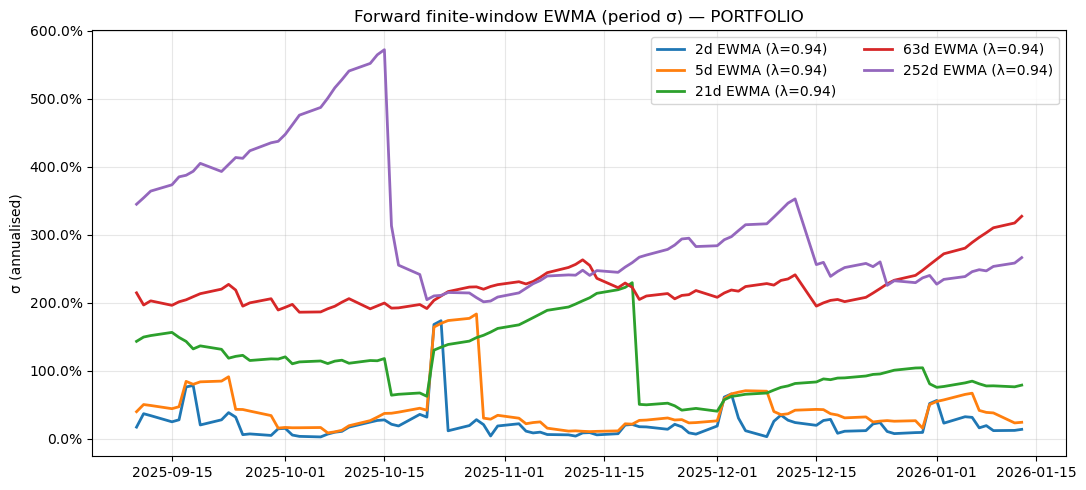

In [77]:
# Portfolio, λ=0.94, show 2/5/21/63/252-day period vols for the next 30 business days

plot_portfolio_vol(lam=0.94)
plot_forward_finite_ewma("PORTFOLIO", windows=(2,5,21,63,252), lam=0.94, future_days=90)

In [78]:
#VAR AND ES

In [79]:
# ========================== VaR & ES (Historical + EWMA-Normal) ==========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import norm
from pathlib import Path

# ---- Paths -----------------------------------------------------------------------------
DATA_INT = Path(r"C:\Users\quantbase\Desktop\quant\data_int")
FIG_DIR  = Path(r"C:\Users\quantbase\Desktop\quant\figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

# ---- Load portfolio daily returns ------------------------------------------------------
# Prefer r_p from memory; else load from disk.
try:
    r_p
except NameError:
    rp_path = DATA_INT / "portfolio_returns.pkl"
    if not rp_path.exists():
        raise RuntimeError("Portfolio series r_p not found. Save it as data_int/portfolio_returns.pkl first.")
    r_p = pd.read_pickle(rp_path).sort_index()

# Ensure it's a clean 1D series of floats
r_p = pd.Series(r_p).astype(float).sort_index()

# ---- Small utilities ------------------------------------------------------------------
def _pct_axis(ax):
    """Format y-axis as percentages without changing tick locator."""
    ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{100*v:.1f}%"))

def rolling_hist_var_es(r: pd.Series, window: int, alpha: float) -> pd.DataFrame:
    """
    Historical (non-parametric) VaR/ES using rolling window:
    - VaR_α: positive loss number = -quantile at q = (1-α)
    - ES_α:  positive loss number = -mean of returns <= -VaR_α
    We use min_periods ≈ 80% of window so early section isn't all NaN.
    """
    r = r.astype(float)
    q = 1.0 - alpha
    minp = max(1, int(np.ceil(window * 0.8)))

    def _var_f(x):
        # quantile of returns (left tail); numpy handles NaNs via nanpercentile
        # we convert q (0..1) → percentile 0..100
        return float(np.nanpercentile(x, q*100.0))

    def _es_f(x):
        # Expected Shortfall = mean of outcomes in the α left tail
        thr = np.nanpercentile(x, q*100.0)
        tail = x[x <= thr]
        return float(np.nanmean(tail)) if tail.size else np.nan

    roll = r.rolling(window, min_periods=minp)
    var_raw = roll.apply(_var_f, raw=False)
    es_raw  = roll.apply(_es_f,  raw=False)

    # Convert to positive "loss" numbers
    out = pd.DataFrame({
        f"VaR_hist_{alpha:.2f}_{window}": -var_raw,
        f"ES_hist_{alpha:.2f}_{window}":  -es_raw
    })
    return out

def ewma_var_series(x: pd.Series, lam: float = 0.94, backcast_n: int = 60) -> pd.Series:
    """
    Infinite-memory EWMA variance:
      σ_t^2 = λ σ_{t-1}^2 + (1-λ) r_t^2
    - NaN r_t: propagate previous variance.
    - Seed/backcast: mean of first backcast_n valid r^2.
    """
    x = x.astype(float)
    r2 = x * x
    out = pd.Series(index=x.index, dtype=float)

    first_valid = r2.first_valid_index()
    if first_valid is None:
        return out

    seed_samp = r2.loc[first_valid:].dropna().iloc[:max(1, backcast_n)]
    seed = float(seed_samp.mean()) if not seed_samp.empty else float(r2.dropna().mean() or 0.0)
    prev = seed
    for t in x.index:
        rt2 = r2.loc[t]
        curr = prev if np.isnan(rt2) else lam * prev + (1.0 - lam) * rt2
        out.loc[t] = curr
        prev = curr
    return out

def param_normal_var_es_from_sigma(mu: pd.Series, sigma: pd.Series, alpha: float) -> pd.DataFrame:
    """
    Parametric Normal VaR/ES given μ_t and σ_t time series.
    Returns positive "loss" numbers.
    - VaR_α = -( μ_t + σ_t * z_α ), where z_α = Φ^{-1}(1-α) is negative for α>0.5
    - ES_α  = -( μ_t - σ_t * φ(z_α) / (1-α) )
    Notes:
      * We assume left-tail loss (returns more negative than VaR threshold).
      * Using μ_t=0 is common in short-horizon risk (set a vector of zeros).
    """
    z = norm.ppf(1.0 - alpha)        # left-tail quantile (e.g., α=0.95 → z≈-1.645)
    phi = norm.pdf(z)
    var_loss = -(mu + sigma * z)
    es_loss  = -(mu - sigma * (phi / (1.0 - alpha)))
    return pd.DataFrame({
        f"VaR_norm_{alpha:.2f}": var_loss,
        f"ES_norm_{alpha:.2f}":  es_loss
    })

# ---- 1) Historical VaR/ES (rolling windows) ------------------------------------------
ALPHAS   = (0.95, 0.99)
WINDOWS  = (63,252, 1260)

hist_panels = []
for w in WINDOWS:
    for a in ALPHAS:
        hist_panels.append(rolling_hist_var_es(r_p, window=w, alpha=a))

hist_df = pd.concat(hist_panels, axis=1)

# Save historical
hist_df.to_pickle(DATA_INT / "var_es_historical.pkl")

# ---- 2) Parametric (Normal) VaR/ES using EWMA σ --------------------------------------
LAMBDAS = (0.94, 0.97)

param_dict = {}
for lam in LAMBDAS:
    sigma_daily = np.sqrt(ewma_var_series(r_p, lam=lam, backcast_n=60))  # daily σ_t
    # Choice of μ_t: set to zero (short horizon). If you want sample μ, use r_p.rolling(w).mean().
    mu_t = pd.Series(0.0, index=sigma_daily.index)

    frames = []
    for a in ALPHAS:
        frames.append(param_normal_var_es_from_sigma(mu_t, sigma_daily, a))
    param_df = pd.concat(frames, axis=1)
    param_dict[lam] = param_df

    # Save each lambda block
    param_df.to_pickle(DATA_INT / f"var_es_param_normal_lambda{int(lam*100):02d}.pkl")

    



    
# ---- 3) Snapshot table (latest values) -----------------------------------------------
last_dt = r_p.dropna().index.max()

def _last(s):
    try:
        return float(s.dropna().iloc[-1])
    except Exception:
        return np.nan

rows = []
# Historical snapshots
for w in WINDOWS:
    for a in ALPHAS:
        rows.append({
            "model": "Hist",
            "window": w,
            "alpha": a,
            "VaR": _last(hist_df[f"VaR_hist_{a:.2f}_{w}"]),
            "ES":  _last(hist_df[f"ES_hist_{a:.2f}_{w}"]),
        })
# Param Normal snapshots
for lam, df in param_dict.items():
    for a in ALPHAS:
        rows.append({
            "model": f"Normal EWMA λ={lam}",
            "window": None,
            "alpha": a,
            "VaR": _last(df[f"VaR_norm_{a:.2f}"]),
            "ES":  _last(df[f"ES_norm_{a:.2f}"]),
        })

snap = pd.DataFrame(rows)
snap = snap[["model","window","alpha","VaR","ES"]]
print(f"Latest snapshot date: {last_dt.date()}")
display(snap)

# ---- 4) Plot: returns vs VaR bands + exceptions --------------------------------------
def plot_var_bands(returns: pd.Series,
                   var_series: dict,
                   title="Portfolio returns vs VaR bands",
                   save_path: Path = None):
    """
    Plot daily portfolio returns with one or more VaR bands (dict[str->Series]).
    Also mark exceptions (days where r_t < -VaR_t).
    - returns: 1D series of daily returns
    - var_series: {"label": VaR_series_as_positive_loss, ...}
    """
    r = returns.astype(float).dropna()
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(r.index, r.values, lw=0.8, label="Daily returns")

    # Overlay each VaR band (as negative threshold on returns axis)
    legend_labels = ["Daily returns"]
    for lab, v in var_series.items():
        v = pd.Series(v).reindex(r.index)  # align to returns index
        ax.plot(v.index, -v.values, lw=1.4, label=lab)  # plot negative (loss threshold on returns scale)
        legend_labels.append(lab)

        # Exceptions: returns below -VaR
        exc_idx = r.index[r.values < -v.values]
        if len(exc_idx):
            ax.scatter(exc_idx, r.loc[exc_idx].values, s=10)

    ax.axhline(0.0, lw=1, alpha=0.5)
    ax.set_title(title)
    ax.set_ylabel("Return (daily)")
    _pct_axis(ax)
    ax.grid(True, alpha=0.3)
    ax.legend(legend_labels, ncol=2)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=160)
    plt.show()

    
notional = 100_000  # INR
last_dt = r_p.dropna().index[-1]

def fmt_row(row):
    v, e = row["VaR"], row["ES"]
    return (f"{row['model']} | window={row['window']} | α={row['alpha']:.2f} | "
            f"VaR={v:.2%} (₹{v*notional:,.0f}) | ES={e:.2%} (₹{e*notional:,.0f})")

for _, row in snap.iterrows():
    print(fmt_row(row))
print(f"\nAs-of: {last_dt.date()}")


Latest snapshot date: 2025-09-09


,model,window,alpha,VaR,ES
0,Hist,63.0,0.95,0.019153,0.049135
1,Hist,63.0,0.99,0.063814,0.107353
2,Hist,252.0,0.95,0.028944,0.040936
3,Hist,252.0,0.99,0.041406,0.064131
4,Hist,1260.0,0.95,NaN,NaN
5,Hist,1260.0,0.99,NaN,NaN
6,Normal EWMA λ=0.94,NaN,0.95,0.019345,0.024259
7,Normal EWMA λ=0.94,NaN,0.99,0.027360,0.031345
8,Normal EWMA λ=0.97,NaN,0.95,0.022530,0.028254
9,Normal EWMA λ=0.97,NaN,0.99,0.031865,0.036506


Hist | window=63.0 | α=0.95 | VaR=1.92% (₹1,915) | ES=4.91% (₹4,914)
Hist | window=63.0 | α=0.99 | VaR=6.38% (₹6,381) | ES=10.74% (₹10,735)
Hist | window=252.0 | α=0.95 | VaR=2.89% (₹2,894) | ES=4.09% (₹4,094)
Hist | window=252.0 | α=0.99 | VaR=4.14% (₹4,141) | ES=6.41% (₹6,413)
Hist | window=1260.0 | α=0.95 | VaR=nan% (₹nan) | ES=nan% (₹nan)
Hist | window=1260.0 | α=0.99 | VaR=nan% (₹nan) | ES=nan% (₹nan)
Normal EWMA λ=0.94 | window=nan | α=0.95 | VaR=1.93% (₹1,934) | ES=2.43% (₹2,426)
Normal EWMA λ=0.94 | window=nan | α=0.99 | VaR=2.74% (₹2,736) | ES=3.13% (₹3,135)
Normal EWMA λ=0.97 | window=nan | α=0.95 | VaR=2.25% (₹2,253) | ES=2.83% (₹2,825)
Normal EWMA λ=0.97 | window=nan | α=0.99 | VaR=3.19% (₹3,186) | ES=3.65% (₹3,651)

As-of: 2025-09-09


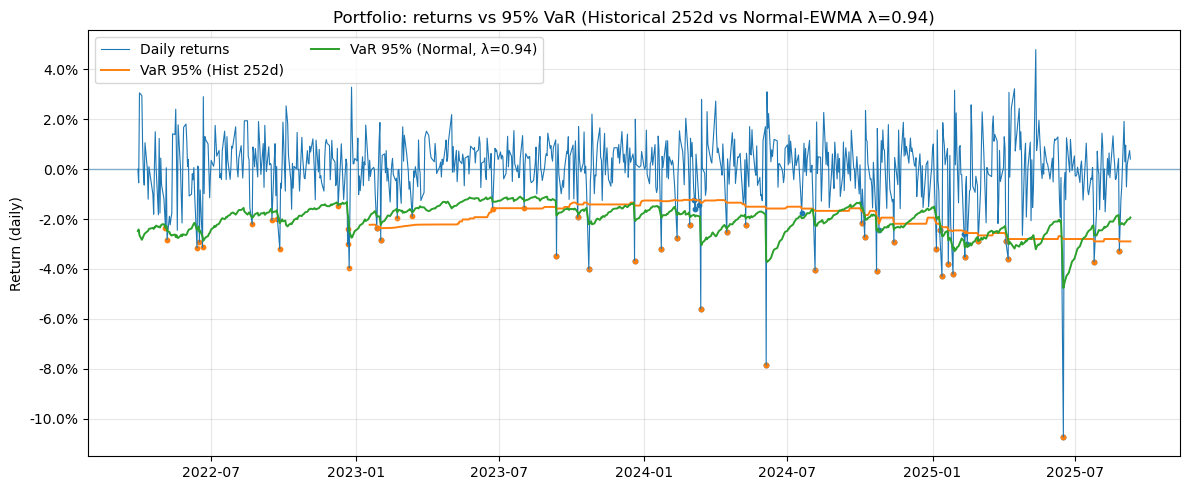

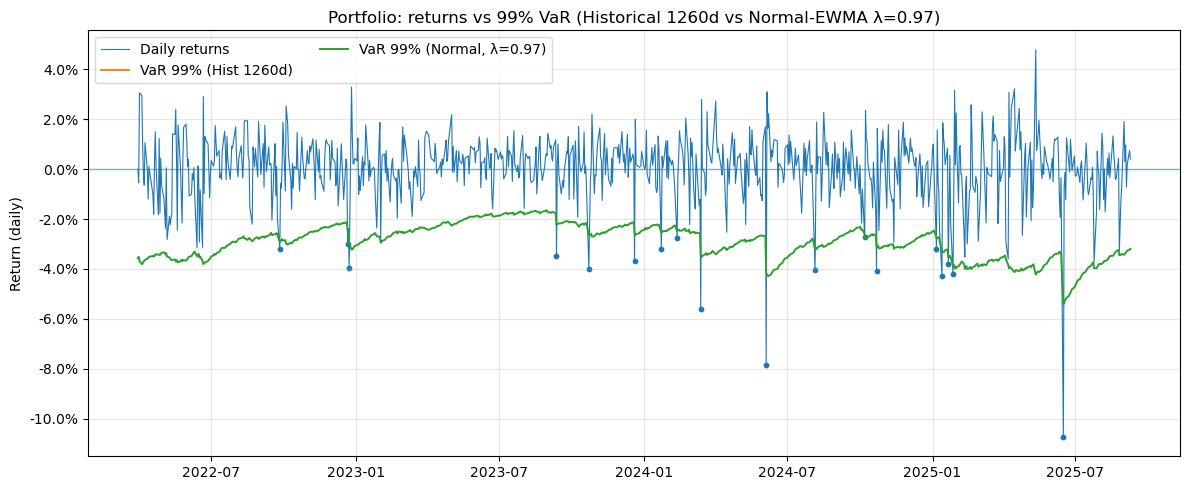

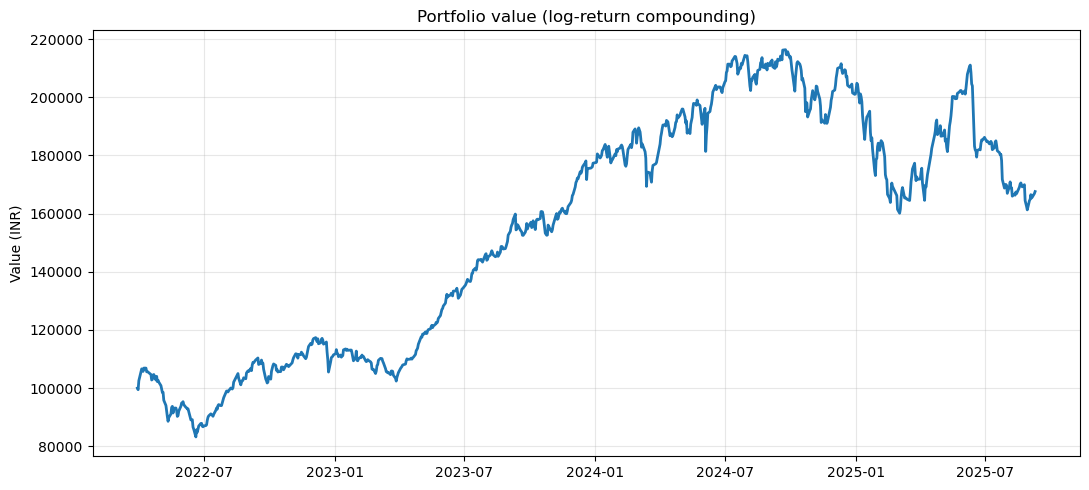


Exception stats (95% hist 252d):
observations           655.000000
exceptions              37.000000
exception_rate           0.056489
expected_exceptions     32.750000
dtype: float64

Exception stats (99% Normal λ=0.94):
observations           856.00000
exceptions              17.00000
exception_rate           0.01986
expected_exceptions      8.56000
dtype: float64


In [80]:
# Example plots:
# 95% hist (252) and 95% Normal-EWMA (λ=0.94)
plot_var_bands(
    r_p,
    var_series={
        "VaR 95% (Hist 252d)": hist_df["VaR_hist_0.95_252"],
        "VaR 95% (Normal, λ=0.94)": param_dict[0.94]["VaR_norm_0.95"]
    },
    title="Portfolio: returns vs 95% VaR (Historical 252d vs Normal-EWMA λ=0.94)",
    save_path=FIG_DIR / "var_bands_95_hist252_vs_norm_l94.png"
)

# 99% bands (Hist 1260) vs Normal-EWMA (λ=0.97)
plot_var_bands(
    r_p,
    var_series={
        "VaR 99% (Hist 1260d)": hist_df["VaR_hist_0.99_1260"],
        "VaR 99% (Normal, λ=0.97)": param_dict[0.97]["VaR_norm_0.99"]
    },
    title="Portfolio: returns vs 99% VaR (Historical 1260d vs Normal-EWMA λ=0.97)",
    save_path=FIG_DIR / "var_bands_99_hist1260_vs_norm_l97.png"
)

# ---- 5) Exceptions summary ------------------------------------------------------------
def exceptions_count(returns: pd.Series, var: pd.Series, alpha: float) -> pd.Series:
    """
    Count VaR exceptions: r_t < -VaR_t.
    Returns a small summary Series with rate vs expected.
    """
    aligned = returns.dropna().align(var.dropna(), join="inner")
    r_al, v_al = aligned[0], aligned[1]
    exc = (r_al < -v_al).sum()
    n   = r_al.size
    expected = (1.0 - alpha) * n
    return pd.Series({
        "observations": n,
        "exceptions": int(exc),
        "exception_rate": exc / n if n else np.nan,
        "expected_exceptions": expected
    })

# Print exception stats (examples)

# ---- 7) Portfolio value curve (default ₹100,000) ----------------------------
portfolio_value = plot_portfolio_value(r_p, V0=100_000)

print("\nException stats (95% hist 252d):")
print(exceptions_count(r_p, hist_df["VaR_hist_0.95_252"], alpha=0.95))

print("\nException stats (99% Normal λ=0.94):")
print(exceptions_count(r_p, param_dict[0.94]["VaR_norm_0.99"], alpha=0.99))


In [81]:
notional = 100_000  # INR
last_dt = r_p.dropna().index[-1]

var95_hist = float(hist_df.loc[last_dt, "VaR_hist_0.95_252"])
var95_norm94 = float(param_dict[0.94].loc[last_dt, "VaR_norm_0.95"])

print(f"95% VaR (Hist 252) on {last_dt.date()}: {var95_hist:.2%}  →  ₹{var95_hist*notional:,.0f}")
print(f"95% VaR (Normal EWMA λ=0.94) on {last_dt.date()}: {var95_norm94:.2%}  →  ₹{var95_norm94*notional:,.0f}")


95% VaR (Hist 252) on 2025-09-09: 2.89%  →  ₹2,894
95% VaR (Normal EWMA λ=0.94) on 2025-09-09: 1.93%  →  ₹1,934


In [82]:
# Backtests

In [83]:
#Speed: Rolling MLE fits for one series and 252-day windows are fine on your data size. If you later find it slow, switch to snapshot (last 252d) with var_es_student_t_snapshot for a quick readout, or run rolling only for the portfolio, not per-stock.

#Interpretation:

#Kupiec p-value low → exception rate doesn’t match α (model miscalibration).

#Independence p-value low → exceptions cluster (model misses time-variation).

#CC p-value low → fails joint coverage (frequency + independence).

#Governance: For limits and reporting, choose the more conservative (larger) of Historical / Normal-EWMA / Student-t at the same α, unless policy states otherwise.

In [84]:
# =========================== Student-t VaR/ES + Backtests ===========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import t as student_t, chi2
from pathlib import Path

# --- Paths & inputs ----------------------------------------------------------------
DATA_INT = Path(r"C:\Users\quantbase\Desktop\quant\data_int")
FIG_DIR  = Path(r"C:\Users\quantbase\Desktop\quant\figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Portfolio daily returns (prefer in-memory r_p; else load)
try:
    r_p
except NameError:
    rp_path = DATA_INT / "portfolio_returns.pkl"
    r_p = pd.read_pickle(rp_path).sort_index()

r_p = pd.Series(r_p).astype(float).sort_index().dropna()

# --- Helpers ------------------------------------------------------------------------
def _pct_axis(ax):
    ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{100*v:.1f}%"))

def fit_student_t(x: np.ndarray):
    """
    MLE fit of Student-t to data in x.
    Returns (nu, loc, scale). Requires len(x) >= 10 to be numerically reasonable.
    """
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]
    if x.size < 10:
        return np.nan, np.nan, np.nan
    try:
        # SciPy returns (df, loc, scale)
        nu, loc, scale = student_t.fit(x)
        # Guard: nu must be > 2 for finite variance; if not, bump slightly.
        if nu <= 2:
            nu = 2.001
        return float(nu), float(loc), float(scale)
    except Exception:
        return np.nan, np.nan, np.nan

def var_es_student_t_series(r: pd.Series, window: int, alpha: float,
                            min_frac: float = 0.8) -> pd.DataFrame:
    """
    Rolling Student-t VaR/ES (positive loss numbers) using MLE fits per window.
    - window: rolling lookback (e.g., 252)
    - alpha:  confidence (e.g., 0.95, 0.99)
    """
    r = r.astype(float)
    minp = max(10, int(np.ceil(window * min_frac)))
    idx = r.index
    var_vals = np.full(len(idx), np.nan, float)
    es_vals  = np.full(len(idx), np.nan, float)

    q_left = 1.0 - alpha  # e.g., 0.05 for 95%
    for i in range(len(idx)):
        j0 = i - window + 1
        if j0 < 0:
            continue
        x = r.iloc[j0:i+1].values
        if np.isfinite(x).sum() < minp:
            continue
        nu, loc, scale = fit_student_t(x)
        if not np.isfinite(nu + loc + scale):
            continue
        # Left-tail quantile (negative): qα = t.ppf(1-α, nu)
        q = student_t.ppf(q_left, df=nu)
        # VaR (loss): -(μ + s q)
        VaR = -(loc + scale * q)

        # ES (loss):  -μ + s * ((ν + q^2)/(ν - 1)) * f(q)/(1-α), for ν > 1
        pdf_q = student_t.pdf(q, df=nu)
        ES = -loc + scale * ((nu + q*q) / (nu - 1.0)) * (pdf_q / (1.0 - alpha))

        var_vals[i] = VaR
        es_vals[i]  = ES

    out = pd.DataFrame({
        f"VaR_t_{alpha:.2f}_{window}": var_vals,
        f"ES_t_{alpha:.2f}_{window}":  es_vals
    }, index=idx)
    return out

def var_es_student_t_snapshot(r: pd.Series, window: int, alpha: float) -> pd.Series:
    """
    Fit Student-t on the last 'window' days only and return {VaR, ES} for the latest date.
    """
    s = r.dropna()
    x = s.iloc[-window:].values if s.size >= window else s.values
    nu, loc, scale = fit_student_t(x)
    q_left = 1.0 - alpha
    q = student_t.ppf(q_left, df=nu)
    VaR = -(loc + scale * q)
    ES  = -loc + scale * ((nu + q*q) / (nu - 1.0)) * (student_t.pdf(q, df=nu) / (1.0 - alpha))
    return pd.Series({"VaR": VaR, "ES": ES, "nu": nu, "mu": loc, "scale": scale})

# --- Backtesting (exceptions + Kupiec + Christoffersen) ------------------------------
def exceptions_series(returns: pd.Series, var_loss: pd.Series) -> pd.Series:
    """
    Boolean series: 1 if r_t < -VaR_t (a breach), else 0. Aligns indices.
    """
    r, v = returns.align(var_loss, join="inner")
    return (r < -v).astype(int)

def kupiec_pof_test(excs: pd.Series, alpha: float) -> pd.Series:
    """
    Kupiec Proportion-of-Failures (unconditional coverage).
    H0: exception rate = p = 1-alpha.
    Returns LR, p-value, obs rate.
    """
    x = int(excs.sum())
    n = int(excs.count())
    if n == 0:
        return pd.Series({"LR": np.nan, "p_value": np.nan, "obs_rate": np.nan, "n": 0, "x": 0})
    p = 1.0 - alpha
    pi = x / float(n) if n > 0 else np.nan
    # Likelihood ratio
    # L0 = (1-p)^{n-x} p^x ; L1 = (1-pi)^{n-x} pi^x
    if pi in (0.0, 1.0):
        # handle edge by adding tiny epsilon
        pi = min(max(pi, 1e-10), 1 - 1e-10)
    L0 = (1 - p)**(n - x) * (p**x if x > 0 else 1.0)
    L1 = (1 - pi)**(n - x) * (pi**x if x > 0 else 1.0)
    LR = -2.0 * np.log(L0 / L1)
    pval = 1.0 - chi2.cdf(LR, df=1)
    return pd.Series({"LR": LR, "p_value": pval, "obs_rate": pi, "n": n, "x": x})

def christoffersen_independence_test(excs: pd.Series) -> pd.Series:
    """
    Christoffersen independence (Markov) test.
    H0: exceptions are independent over time.
    """
    e = excs.dropna().astype(int).values
    if e.size < 2:
        return pd.Series({"LR": np.nan, "p_value": np.nan})
    n00 = n01 = n10 = n11 = 0
    for i in range(1, e.size):
        a, b = e[i-1], e[i]
        if   a==0 and b==0: n00 += 1
        elif a==0 and b==1: n01 += 1
        elif a==1 and b==0: n10 += 1
        else:               n11 += 1
    n0 = n00 + n01
    n1 = n10 + n11
    # Transition probabilities
    pi01 = n01 / float(max(n0, 1))
    pi11 = n11 / float(max(n1, 1))
    # Unconditional probability
    pi = (n01 + n11) / float(max(n0 + n1, 1))
    # Likelihoods (avoid log(0) with eps)
    eps = 1e-12
    L0 = ((1 - pi + eps)**n00) * ((pi + eps)**n01) * ((1 - pi + eps)**n10) * ((pi + eps)**n11)
    L1 = ((1 - pi01 + eps)**n00) * ((pi01 + eps)**n01) * ((1 - pi11 + eps)**n10) * ((pi11 + eps)**n11)
    LR = -2.0 * np.log(L0 / L1)
    pval = 1.0 - chi2.cdf(LR, df=1)
    return pd.Series({"LR": LR, "p_value": pval,
                      "n00": n00, "n01": n01, "n10": n10, "n11": n11})

def christoffersen_conditional_coverage(LR_pof: float, LR_ind: float) -> pd.Series:
    """
    Joint (conditional coverage): LR_cc = LR_pof + LR_ind, df = 2.
    """
    LR = LR_pof + LR_ind
    pval = 1.0 - chi2.cdf(LR, df=2)
    return pd.Series({"LR": LR, "p_value": pval})

# --- Compute rolling t-VaR/ES series (95/99, window=252) ------------------------------
ALPHAS  = (0.95, 0.99)
WIN_T   = 63

t_panels = []
for a in ALPHAS:
    t_panels.append(var_es_student_t_series(r_p, window=WIN_T, alpha=a))
t_df = pd.concat(t_panels, axis=1)

# Save
t_df.to_pickle(DATA_INT / f"var_es_param_t_{WIN_T}.pkl")

# --- Snapshot add-on (extend your existing 'snap' table if present) --------------------
# If you already have 'snap' from earlier, we will append; else build a new one.
try:
    snap
except NameError:
    snap = pd.DataFrame(columns=["model","window","alpha","VaR","ES"])

last_dt = r_p.index.max()
rows = []
for a in ALPHAS:
    rows.append({
        "model": "Student-t (MLE)",
        "window": WIN_T,
        "alpha": a,
        "VaR": float(t_df[f"VaR_t_{a:.2f}_{WIN_T}"].dropna().iloc[-1]),
        "ES":  float(t_df[f"ES_t_{a:.2f}_{WIN_T}"].dropna().iloc[-1]),
    })
snap = pd.concat([snap, pd.DataFrame(rows)], ignore_index=True)
display(snap)

# --- Plot: returns vs Student-t VaR (with exceptions) ---------------------------------
def plot_var_bands_t(returns: pd.Series, t_var_series: pd.Series,
                     title="Portfolio: returns vs Student-t VaR",
                     save_path: Path = None):
    r = returns.dropna()
    v = t_var_series.reindex(r.index)
    exc = r < -v
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(r.index, r.values, lw=0.8, label="Daily returns")
    ax.plot(v.index, -v.values, lw=1.4, label=t_var_series.name or "t-VaR")
    # Mark exceptions
    ax.scatter(r.index[exc], r.values[exc], s=12, color="C3", label="Exceptions")
    ax.axhline(0.0, lw=1, alpha=0.5)
    ax.set_title(title)
    ax.set_ylabel("Return (daily)")
    _pct_axis(ax)
    ax.grid(True, alpha=0.3)
    ax.legend(ncol=2)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=160)
    plt.show()



,model,window,alpha,VaR,ES
0,Hist,63.0,0.95,0.019153,0.049135
1,Hist,63.0,0.99,0.063814,0.107353
2,Hist,252.0,0.95,0.028944,0.040936
3,Hist,252.0,0.99,0.041406,0.064131
4,Hist,1260.0,0.95,NaN,NaN
5,Hist,1260.0,0.99,NaN,NaN
6,Normal EWMA λ=0.94,NaN,0.95,0.019345,0.024259
7,Normal EWMA λ=0.94,NaN,0.99,0.027360,0.031345
8,Normal EWMA λ=0.97,NaN,0.95,0.022530,0.028254
9,Normal EWMA λ=0.97,NaN,0.99,0.031865,0.036506


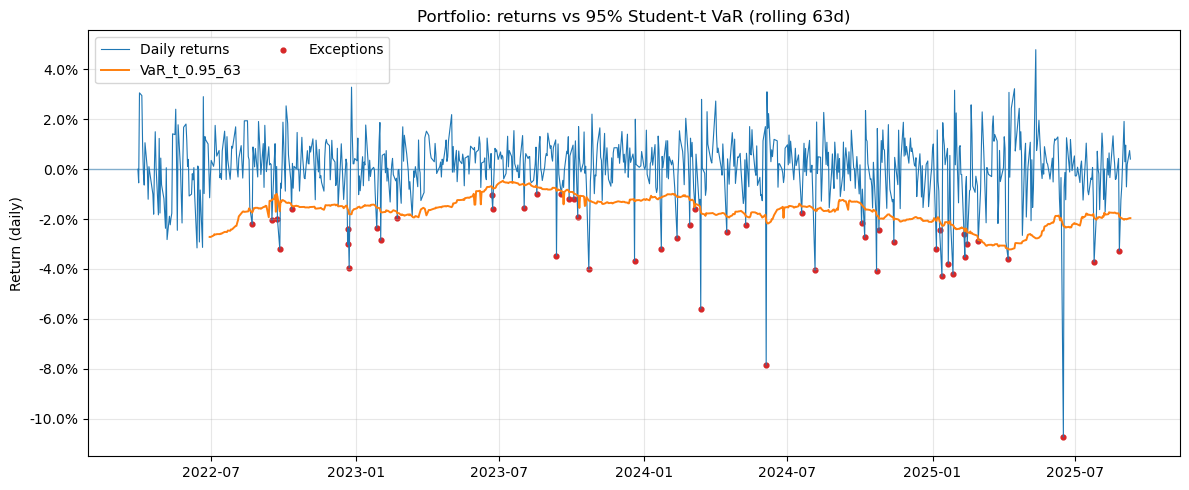

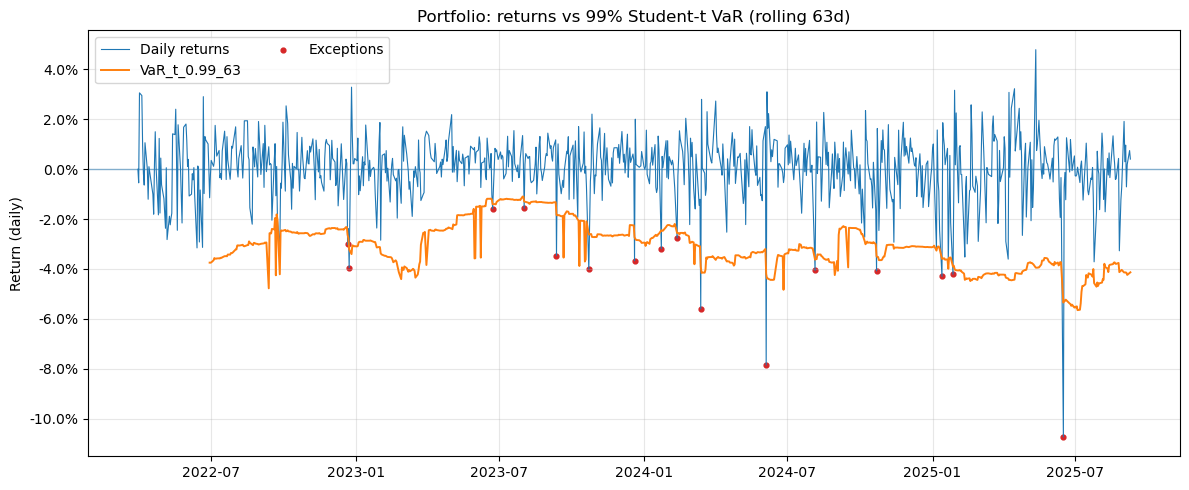


Backtest — 95% Student-t VaR


,alpha,kupiec_LR,kupiec_p_value,kupiec_obs_rate,kupiec_n,kupiec_x,indep_LR,indep_p_value,indep_n00,indep_n01,indep_n10,indep_n11,cc_LR,cc_p_value
0,0.95,1.212427,0.270852,0.058411,856.0,50.0,2.897237,0.088732,761.0,44.0,44.0,6.0,4.109665,0.128114



Backtest — 99% Student-t VaR


,alpha,kupiec_LR,kupiec_p_value,kupiec_obs_rate,kupiec_n,kupiec_x,indep_LR,indep_p_value,indep_n00,indep_n01,indep_n10,indep_n11,cc_LR,cc_p_value
0,0.99,5.201144,0.022572,0.018692,856.0,16.0,0.610287,0.43468,823.0,16.0,16.0,0.0,5.811431,0.05471


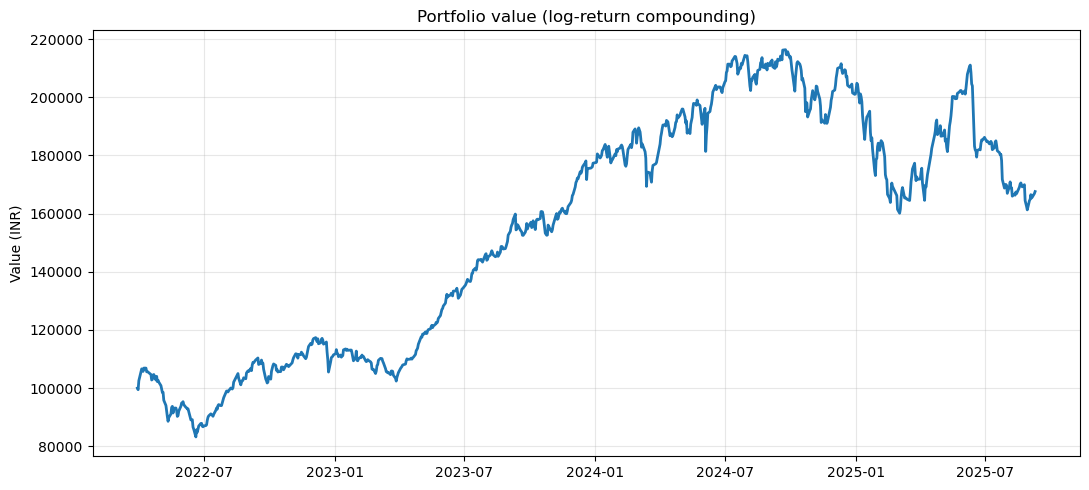

In [85]:
# Examples (pick one alpha to visualize)
plot_var_bands_t(
    r_p,
    t_df[f"VaR_t_0.95_{WIN_T}"],
    title=f"Portfolio: returns vs 95% Student-t VaR (rolling {WIN_T}d)",
    save_path=FIG_DIR / f"var_bands_t_95_{WIN_T}.png"
)

plot_var_bands_t(
    r_p,
    t_df[f"VaR_t_0.99_{WIN_T}"],
    title=f"Portfolio: returns vs 99% Student-t VaR (rolling {WIN_T}d)",
    save_path=FIG_DIR / f"var_bands_t_99_{WIN_T}.png"
)

# --- Backtests on the Student-t VaR series --------------------------------------------
def backtest_report(returns: pd.Series, var_series: pd.Series, alpha: float) -> pd.Series:
    exc = exceptions_series(returns, var_series)
    kup = kupiec_pof_test(exc, alpha=alpha)
    ind = christoffersen_independence_test(exc)
    cc  = christoffersen_conditional_coverage(kup["LR"], ind["LR"])
    out = pd.concat([
        pd.Series({"alpha": alpha}),
        kup.add_prefix("kupiec_"),
        ind.add_prefix("indep_"),
        cc.add_prefix("cc_")
    ])
    return out

bt95 = backtest_report(r_p, t_df[f"VaR_t_0.95_{WIN_T}"], alpha=0.95)
bt99 = backtest_report(r_p, t_df[f"VaR_t_0.99_{WIN_T}"], alpha=0.99)

print("\nBacktest — 95% Student-t VaR")
display(bt95.to_frame().T)

print("\nBacktest — 99% Student-t VaR")
display(bt99.to_frame().T)


# ---- 7) Portfolio value curve (default ₹100,000) ----------------------------
portfolio_value = plot_portfolio_value(r_p, V0=100_000)

In [86]:
# PORT VOL CONTRIBUTION

In [87]:
# ===================== Portfolio σ contributions (252d covariance) =====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pathlib import Path

DATA_INT = Path(r"C:\Users\quantbase\Desktop\quant\data_int")
FIG_DIR  = Path(r"C:\Users\quantbase\Desktop\quant\figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

# --- Load daily returns ---------------------------------------------------------------
r_1d = pd.read_pickle(DATA_INT / "log_returns_daily.pkl").sort_index()

# --- Bring weights -------------------------------------------------------------------
# Priority: use in-memory 'weights' (Series or dict) if present; else try CSV at data_int/portfolio_weights.csv
try:
    weights  # may be dict/Series from earlier
    if isinstance(weights, dict):
        w = pd.Series(weights, dtype=float)
    else:
        w = pd.Series(weights, dtype=float)
except NameError:
    w_path = DATA_INT / "portfolio_weights.csv"   # expected columns: symbol, weight (in decimal, e.g. 0.0723)
    if not w_path.exists():
        raise RuntimeError("Weights not found. Provide `weights` in memory or save data_int/portfolio_weights.csv "
                           "with columns: symbol, weight (decimal).")
    w = pd.read_csv(w_path).set_index("symbol")["weight"].astype(float)

# Align weights to returns columns; fill missing with 0
w = w.reindex(r_1d.columns).fillna(0.0)
# Renormalize gently if needed
w_sum = float(w.sum())
if not np.isclose(w_sum, 1.0):
    if w_sum <= 0:
        raise RuntimeError("Weights sum ≤ 0. Please supply valid positive weights.")
    w = w / w_sum





In [88]:
# --- 252d window covariance -----------------------------------------------------------
WIN = 252
# take the last 252 obs (or fewer if shorter), pairwise NaN-safe cov
r_tail = r_1d.tail(WIN)
Sigma  = r_tail.cov()   # (n x n) covariance matrix, daily units

# --- Portfolio σ, marginal & component contributions ---------------------------------
# σ_p = sqrt(w' Σ w)
sigma_p = float(np.sqrt(np.dot(w.values, np.dot(Sigma.values, w.values))))

# Marginal contribution (per asset): MC_i = (Σ w)_i / σ_p  [daily]
mc_vec = Sigma.dot(w).values  # vector Σ w
mc = pd.Series(mc_vec / sigma_p, index=w.index) if sigma_p > 0 else pd.Series(0.0, index=w.index)

# Component contribution: CC_i = w_i * MC_i  [daily contribution to σ_p]
cc = (w * mc)

# Percentage contribution: CC_i / σ_p
pct_cc = cc / sigma_p if sigma_p > 0 else cc * 0.0

# Assemble table
risk_contrib = pd.DataFrame({
    "weight": w,
    "marginal_sigma_daily": mc,
    "component_sigma_daily": cc,
    "pct_of_port_sigma": pct_cc
}).sort_values("pct_of_port_sigma", ascending=False)

# Add annualised columns for readability
risk_contrib["marginal_sigma_annual"]  = risk_contrib["marginal_sigma_daily"]  * np.sqrt(252.0)
risk_contrib["component_sigma_annual"] = risk_contrib["component_sigma_daily"] * np.sqrt(252.0)

# Sanity rows
totals = pd.Series({
    "weight": risk_contrib["weight"].sum(),
    "marginal_sigma_daily": np.nan,  # not additive
    "component_sigma_daily": risk_contrib["component_sigma_daily"].sum(),
    "pct_of_port_sigma": risk_contrib["pct_of_port_sigma"].sum(),
    "marginal_sigma_annual": np.nan,
    "component_sigma_annual": risk_contrib["component_sigma_annual"].sum()
}, name="__TOTALS__")
risk_contrib = pd.concat([risk_contrib, totals.to_frame().T])

# Save
out_csv = DATA_INT / "portfolio_risk_contrib_252.csv"
risk_contrib.to_csv(out_csv)
print(f"Saved: {out_csv}")

Saved: C:\Users\quantbase\Desktop\quant\data_int\portfolio_risk_contrib_252.csv


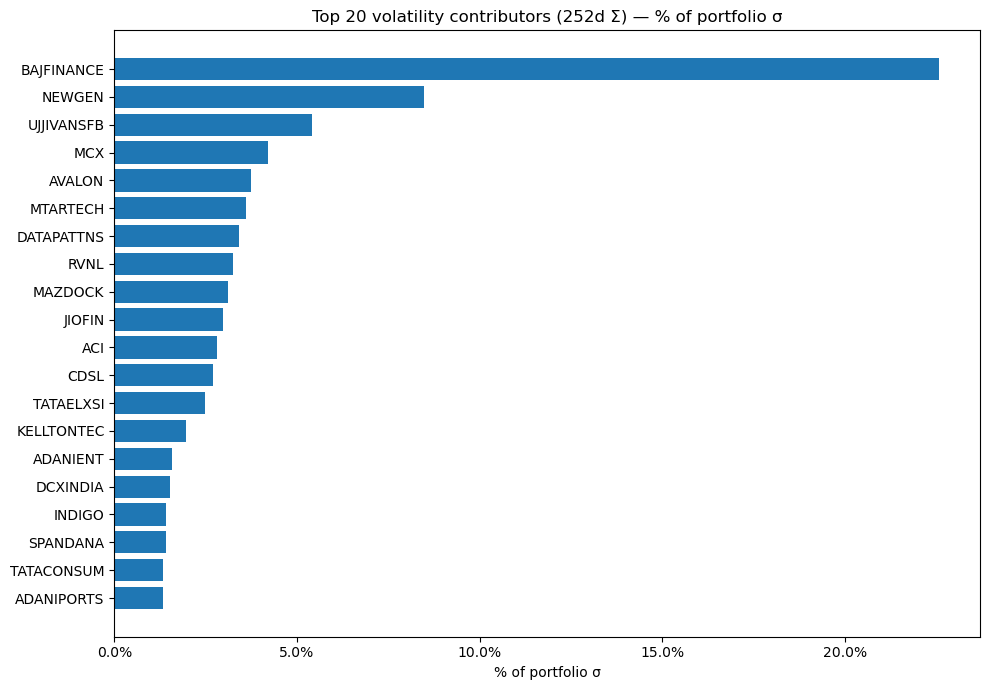

Saved: C:\Users\quantbase\Desktop\quant\figures\portfolio_risk_contrib_252.png
Portfolio σ (daily):  1.54%
Portfolio σ (annual): 24.50%


In [89]:
# --- Plot: top contributors (percentage of σ_p) ---------------------------------------
def _fmt_pct_axis(ax):
    ax.xaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{100*v:.1f}%"))

top_n = 20
plot_df = risk_contrib.drop(index="__TOTALS__", errors="ignore").head(top_n)

fig, ax = plt.subplots(figsize=(10, max(5, int(0.35*len(plot_df)))))
ax.barh(plot_df.index[::-1], plot_df["pct_of_port_sigma"].values[::-1])
ax.set_title(f"Top {top_n} volatility contributors (252d Σ) — % of portfolio σ")
ax.set_xlabel("% of portfolio σ")
_fmt_pct_axis(ax)
plt.tight_layout()
fig_path = FIG_DIR / "portfolio_risk_contrib_252.png"
plt.savefig(fig_path, dpi=160)
plt.show()
print(f"Saved: {fig_path}")

# Print headline σ
print(f"Portfolio σ (daily):  {sigma_p:.2%}")
print(f"Portfolio σ (annual): {sigma_p*np.sqrt(252):.2%}")


In [90]:
# PORTFOLIO SNAPSHOT

In [91]:
# =========================== Risk dashboard (latest snapshot) ===========================
import numpy as np
import pandas as pd
from pathlib import Path

DATA_INT = Path(r"C:\Users\quantbase\Desktop\quant\data_int")

# --- Load portfolio daily returns ------------------------------------------------------
try:
    r_p
except NameError:
    rp_path = DATA_INT / "portfolio_returns.pkl"
    r_p = pd.read_pickle(rp_path).sort_index()
r_p = pd.Series(r_p).astype(float).sort_index().dropna()

# --- Small helpers --------------------------------------------------------------------
def realized_vol(x: pd.Series, window: int) -> pd.Series:
    """Realised (sample) volatility over rolling window (daily units)."""
    return x.rolling(window, min_periods=max(2, int(window*0.8))).std(ddof=1)

def ewma_var_series(x: pd.Series, lam: float = 0.94, backcast_n: int = 60) -> pd.Series:
    """Recursive EWMA variance; daily units."""
    x = x.astype(float)
    r2 = x * x
    out = pd.Series(index=x.index, dtype=float)
    fv = r2.first_valid_index()
    if fv is None:
        return out
    seed = float(r2.loc[fv:].dropna().iloc[:max(1, backcast_n)].mean())
    prev = seed
    for t in x.index:
        rt2 = r2.loc[t]
        curr = prev if np.isnan(rt2) else lam*prev + (1-lam)*rt2
        out.loc[t] = curr
        prev = curr
    return out

def last_non_nan(s: pd.Series) -> float:
    return float(s.dropna().iloc[-1]) if s.dropna().size else np.nan

# --- σ section ------------------------------------------------------------------------
sig_real_21  = realized_vol(r_p, 21)
sig_real_63  = realized_vol(r_p, 63)
sig_real_252 = realized_vol(r_p, 252)

sig_ewma_94 = np.sqrt(ewma_var_series(r_p, lam=0.94))
sig_ewma_97 = np.sqrt(ewma_var_series(r_p, lam=0.97))

row_sigma = {
    "metric": "volatility",
    "σ_real_21_d":  last_non_nan(sig_real_21),
    "σ_real_63_d":  last_non_nan(sig_real_63),
    "σ_real_252_d": last_non_nan(sig_real_252),
    "σ_EWMA_0.94_d": last_non_nan(sig_ewma_94),
    "σ_EWMA_0.97_d": last_non_nan(sig_ewma_97),
}
# annualised versions
row_sigma.update({
    "σ_real_21_ann":  row_sigma["σ_real_21_d"]  * np.sqrt(252.0) if pd.notna(row_sigma["σ_real_21_d"])  else np.nan,
    "σ_real_63_ann":  row_sigma["σ_real_63_d"]  * np.sqrt(252.0) if pd.notna(row_sigma["σ_real_63_d"])  else np.nan,
    "σ_real_252_ann": row_sigma["σ_real_252_d"] * np.sqrt(252.0) if pd.notna(row_sigma["σ_real_252_d"]) else np.nan,
    "σ_EWMA_0.94_ann":row_sigma["σ_EWMA_0.94_d"]* np.sqrt(252.0) if pd.notna(row_sigma["σ_EWMA_0.94_d"]) else np.nan,
    "σ_EWMA_0.97_ann":row_sigma["σ_EWMA_0.97_d"]* np.sqrt(252.0) if pd.notna(row_sigma["σ_EWMA_0.97_d"]) else np.nan,
})

# --- VaR/ES section (load if available) -----------------------------------------------
rows_var = []
# Historical (combined file)
p_hist = DATA_INT / "var_es_historical.pkl"
if p_hist.exists():
    hist_df = pd.read_pickle(p_hist)
    for a in (0.95, 0.99):
        for w in (252, 1260):
            rows_var.append({
                "model": f"Hist_{w}",
                "alpha": a,
                "VaR": last_non_nan(hist_df.get(f"VaR_hist_{a:.2f}_{w}", pd.Series(dtype=float))),
                "ES":  last_non_nan(hist_df.get(f"ES_hist_{a:.2f}_{w}",  pd.Series(dtype=float))),
            })

# Normal-EWMA
for lam in (0.94, 0.97):
    p = DATA_INT / f"var_es_param_normal_lambda{int(lam*100):02d}.pkl"
    if p.exists():
        df = pd.read_pickle(p)
        for a in (0.95, 0.99):
            rows_var.append({
                "model": f"Normal_EWMA_{lam}",
                "alpha": a,
                "VaR": last_non_nan(df.get(f"VaR_norm_{a:.2f}", pd.Series(dtype=float))),
                "ES":  last_non_nan(df.get(f"ES_norm_{a:.2f}",  pd.Series(dtype=float))),
            })

# Student-t
p_t = DATA_INT / "var_es_param_t_252.pkl"
if p_t.exists():
    t_df = pd.read_pickle(p_t)
    for a in (0.95, 0.99):
        rows_var.append({
            "model": "StudentT_252",
            "alpha": a,
            "VaR": last_non_nan(t_df.get(f"VaR_t_{a:.2f}_252", pd.Series(dtype=float))),
            "ES":  last_non_nan(t_df.get(f"ES_t_{a:.2f}_252",  pd.Series(dtype=float))),
        })

dashboard = pd.DataFrame([row_sigma])
var_tab   = pd.DataFrame(rows_var)

# Save
dash_path = DATA_INT / "dashboard_snapshot.csv"
dashboard.to_csv(dash_path, index=False)
print(f"Saved: {dash_path}")

if not var_tab.empty:
    var_path = DATA_INT / "dashboard_var_es_snapshot.csv"
    var_tab.to_csv(var_path, index=False)
    print(f"Saved: {var_path}")

display(dashboard)  # vols (daily + annual)
if not var_tab.empty:
    display(var_tab.sort_values(["alpha","model"]))


Saved: C:\Users\quantbase\Desktop\quant\data_int\dashboard_snapshot.csv
Saved: C:\Users\quantbase\Desktop\quant\data_int\dashboard_var_es_snapshot.csv


,metric,σ_real_21_d,σ_real_63_d,σ_real_252_d,σ_EWMA_0.94_d,σ_EWMA_0.97_d,σ_real_21_ann,σ_real_63_ann,σ_real_252_ann,σ_EWMA_0.94_ann,σ_EWMA_0.97_ann
0,volatility,0.0112,0.016768,0.015422,0.011761,0.013697,0.1778,0.266185,0.244819,0.186697,0.217438


,model,alpha,VaR,ES
1,Hist_1260,0.95,NaN,NaN
0,Hist_252,0.95,0.028944,0.040936
4,Normal_EWMA_0.94,0.95,0.019345,0.024259
6,Normal_EWMA_0.97,0.95,0.022530,0.028254
8,StudentT_252,0.95,0.022299,0.035056
3,Hist_1260,0.99,NaN,NaN
2,Hist_252,0.99,0.041406,0.064131
5,Normal_EWMA_0.94,0.99,0.027360,0.031345
7,Normal_EWMA_0.97,0.99,0.031865,0.036506
9,StudentT_252,0.99,0.041194,0.059981
